# Modeling Integrase-Excisionase Activity
The goal of this notebook is to model integrase-excisionase activity in TX-TL using mechanistic chemical reaction network models and Bayesian inference.

## 1. Integrase Expression and Activitiy Modeling:
The first step is to characterize integrase activity independent of the excisionase. For this, we design a two plasmid system - (1) Bxb1 integrase expressing plasmid fused with CFP to measure integrase expression, and (2) YFP plasmid that gets activated on integrase action. Hence, using this experiment we would like to model integrase expression and its action on flipping a promoter of a fluorescent reporter. The goal of the experiment would be to characterize the integrase flipping activity parameter(s) and to study any context effects due to TX-TL such as loading. 

Towards this first goal, we model the two plasmid system in TX-TL using a mechanistic chemical reaction network using BioCRNpyler. We simulate this detailed CRN model using a fast Cython-based simulator called Bioscrape. From simulations of the CRN model, we explore the design space and context effects since this model consists the details of resource usage mechanisms for RNA polymerase, ribosomes, etc. However, the detailed model is difficult to fit using the available data due to the problem of unidentifiability and high-dimensionality. We explore these effects by running sensitivity analysis tools implemented as part of the Bioscrape software. To get around this problem of unidentifiability, we automatically derive potential reduced models for this system using Python-based automated model reduction software called, AutoReduce. We choose a reduced model that recovers the desired properties (integrase flipping, fluorescent reporter levels, and any other important context effects). For this lower-dimensional reduced model, we use Bayesian inference to fit the TX-TL data. The parameter inference pipeline is implemented in Bioscrape as a black-box Python wrapper for Python emcee. Hence, the "full-stack" Python pipeline of modeling, design-space exploration, sensitivity analysis, model reduction, and parameter inference gives us a validated mathematical model for integrase activity in TX-TL. 

## 2. Excisionase Expression Modeling:
To characterize the excisionase activity, we design a second experiment that consists of an excisionase-GFP plasmid. The goal of this experiment is to characterize the expression of excisionase in TX-TL. Similar to the integrase experiment, we model the excisionase-GFP plasmid in TX-TL using BioCRNpyler with context effects. Following similar process through the automated pipeline, the goal is to obtain parameters pertaining to the mechanisms in expressing excisionase in solution and its corresponding fluorescent reporter expression. 

## 3. Integrase-Excisionase Modeling:
Once we have the validated models for the integrase expression, integrase action, and excisionase expression, we can develop a mathematical model for the combined system to predict the integrase-excisionase activity using the model. Using our model predictions, we would like to guide the design of this final experiment with all three plasmids.

The Jupyter notebook consists of modeling for each of these sections, starting with the first one on integrase expression and acitivity modeling:

# Integrase Expression and Activity Modeling

The two-plasmid system is shown below:


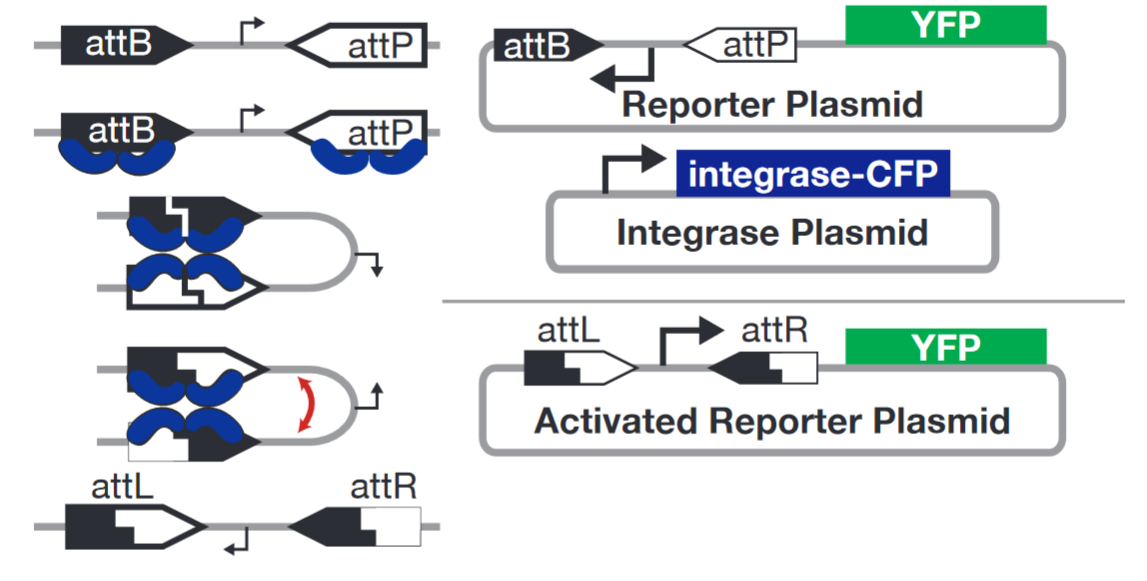

## Chemical Reaction Network (CRN) models:

In [1]:
##
# Author: Ayush Pandey
##
from biocrnpyler import *

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rc('text', usetex=False)
# mpl.rc('text.latex', preamble=r'\usepackage{helvet}\
# \renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5, titlesize=14, labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Integrase flipping CRN:

$attB + 2 I \rightleftharpoons attB:I_2$

$attP + 2 I \rightleftharpoons attP:I_2$

$attB:I_2 + attP:I_2 \xrightarrow{k_{int}} attL:I_2 + attR:I_2$

$attL:I_2 + attR:I_2 \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$

where $I$ is the integrase, $A$ is activated plasmid (integrase flipped) and $Y$ is the reporter protein concentration.

We can further simplify the above integrase flipping CRN to represent the measurements that we have for integrase and flipped plasmid (CFP and YFP respectively).

Let R = unactivated reporter plasmid = attB--attP plasmid. So we can write:

$ \varnothing \rightarrow I $

$n_I \cdot I + R \rightleftharpoons C_I$

$C_I \rightarrow C_A$

$C_A \rightleftharpoons A + n_I \cdot I$

$ A \rightarrow Y + A$ (TX-TL reactions)


The above integrase flipping module can be modeled in a TX-TL context using BioCRNpyler.

Similar to the integrase model, we can write a chemical reaction network for the excisionase activity,

We have the activated plasmid A which has the attL and attR sites as a result of integrase activity. The excisionase can bind to these sites on the plasmid and convert these to the attP and attB sites, resulting in the flipping of the promoter back so that it is unactivated (that is, R). So we can write:


$ \varnothing \rightarrow E $

$n_E\cdot E + C_I \rightleftharpoons C_R$

$n_E\cdot E + C_A \rightleftharpoons C_E$

$C_E \rightarrow C_R$

$C_R \rightleftharpoons R + n_E \cdot E + n_I \cdot I$

and 

$I + E \rightleftharpoons C_{IE}$

$n_{IE} C_{IE} + A \rightleftharpoons C_{E}$

$n_{IE}C_{IE} + R\rightleftharpoons C_R$


### Create IntegraseSite component and IntegraseFlipper mechanism to model integrase activity

In [3]:
from itertools import chain
class IntegraseSite(Component):
    def __init__(self, integrase: Species, 
                 curr_dna: Species, reversed_dna: Species, 
                 name: str=None, cooperativity: int=1, parameter_dict = None,
                 mechanism = None, **keywords):

#         self.species = Complex(species=self.internal_species, name=name, 
#         material_type=material_type, attributes=attributes)
        if name is None:
            name = integrase.name
        self.name = name
        self.integrase = integrase
        self.curr_dna = curr_dna
        self.reversed_dna = reversed_dna
        self.complex_species = None
        self.flipped_complex = None
        self.species = None
#         self.species = [integrase, curr_dna, reversed_dna]
        self.cooperativity = cooperativity
        self.parameter_dict = parameter_dict
        mechanisms = {mechanism.mechanism_type:mechanism}
        Component.__init__(self=self, name=name, mechanisms=mechanisms, **keywords)
        
    def get_species(self) -> List[Species]:
        return self.species

    def update_species(self) -> List[Species]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        self.species = integrase_flipper.update_species(integrase = self.integrase, 
                                                        curr_dna = self.curr_dna, 
                                                        reversed_dna = self.reversed_dna, 
                                                        cooperativity = self.cooperativity)
        return self.species

    def update_reactions(self) -> List[Reaction]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        return integrase_flipper.update_reactions(integrase = self.integrase, curr_dna = self.curr_dna, 
                                                  reversed_dna = self.reversed_dna, cooperativity = self.cooperativity,
                                                  complex_species = self.complex_species, 
                                                  flipped_complex = self.flipped_complex, 
                                                  component = self, 
                                                  part_id = None, parameter_dict = self.parameter_dict)


class IntegraseFlipper(Mechanism):
    """Mechanism for the simple integrase flipping. 
    Integrase binds to attP-attB site, forms a complex,
    the complex flips the site to attL-attR, then integrase unbinds.
    """
    def __init__(self, name: str="integrase-flipper", mechanism_type: str="integrase-flipper", **keywords):
        """Initializes a IntegraseFlipper instance.
        :param name: name of the Mechanism, default: integrase-flipper
        :param mechanism_type: type of the Mechanism, default: integrase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)

    def update_species(self, integrase, curr_dna, reversed_dna, cooperativity):
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        # attP_attB_4I
        complex_species = Complex(species = list_of_species)
        self.complex_species = complex_species
        # attL_attR_4I
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        flipped_complex = Complex(species = list_of_species)
        self.flipped_complex = flipped_complex
        return [integrase, curr_dna, reversed_dna, 
                complex_species, flipped_complex]

    def update_reactions(self, integrase, curr_dna, reversed_dna, cooperativity,
                         complex_species, flipped_complex, component = None, 
                         part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_i = component.get_parameter("a_i", part_id = part_id, mechanism = self)
            d_i = component.get_parameter("d_i", part_id = part_id, mechanism = self)
            k_int = component.get_parameter("k_int", part_id = part_id, mechanism = self)
            a_r = component.get_parameter("a_r", part_id = part_id, mechanism = self)
            d_r = component.get_parameter("d_r", part_id = part_id, mechanism = self)
        else:
            a_i = parameter_dict['a_i']
            d_i = parameter_dict['d_i']
            k_int = parameter_dict['k_int']
            a_r = parameter_dict['a_r']
            d_r = parameter_dict['d_r']
        
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex   
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        integrase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species for item in sublist],
                                                              [complex_species],
                                                              k_forward = a_i, k_reverse = d_i)
        flipping_reaction = Reaction.from_massaction([complex_species], [flipped_complex], k_forward = k_int)
        
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        integrase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species for item in sublist],
                                                                k_forward = a_r, k_reverse = d_r)
        reactions = [integrase_binding_reaction, flipping_reaction, integrase_unbinding_reaction]
        return reactions

### Excisionase component

In [4]:
from itertools import chain
class ExcisionaseSite(Component):
    def __init__(self, excisionase: Species, integrase_site: Component,
                 curr_dna: Species, reversed_dna: Species,
                 name: str=None, cooperativity: int=1, parameter_dict = None,
                 mechanism = None, **keywords):

        if name is None:
            name = excisionase.name
        self.name = name
        self.excisionase = excisionase # E
        self.curr_dna = curr_dna # A 
        self.reversed_dna = reversed_dna # R
        integrase_site.update_species()
        self.integrase_site = integrase_site
        self.complex_species = None
        self.flipped_complex = None
        self.integrase_excisionase_complex = None
        self.species = None
#         self.species = [excisionase, curr_dna, reversed_dna]
#         for species in integrase_site.species:
#             self.species.append(species)
        self.cooperativity = cooperativity
        self.parameter_dict = parameter_dict
        mechanisms = {mechanism.mechanism_type:mechanism}
        self.mechanism_type = mechanism.mechanism_type
        Component.__init__(self=self, name=name, mechanisms=mechanisms, **keywords)
        
    def get_species(self) -> List[Species]:
        return self.species

    def update_species(self) -> List[Species]:
        excisionase_flipper = self.get_mechanism(self.mechanism_type)
        self.species = excisionase_flipper.update_species(excisionase = self.excisionase, 
                                                          curr_dna = self.curr_dna, 
                                                          reversed_dna = self.reversed_dna, 
                                                          cooperativity = self.cooperativity,
                                                          integrase_site = self.integrase_site)
        return self.species
        

    def update_reactions(self) -> List[Reaction]:
        xis_flipper = self.get_mechanism(self.mechanism_type)
        return xis_flipper.update_reactions(excisionase = self.excisionase, 
                                            curr_dna = self.curr_dna, 
                                            reversed_dna = self.reversed_dna, 
                                            cooperativity = self.cooperativity,
                                            integrase_site = self.integrase_site, 
                                            complex_species = self.complex_species,
                                            flipped_complex = self.flipped_complex, 
                                            integrase_excisionase_complex = self.integrase_excisionase_complex,
                                            component = self, part_id = None, parameter_dict = self.parameter_dict)
   
    
class ExcisionaseFlipper(Mechanism):
    """Mechanism for the excisionase flipping. 
    Excisionase binds to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase unbinds.
    Both binding of excisionase directly to the integrase-dna complex and
    first binding to integrase then to DNA are allowed.
    """
    def __init__(self, name: str="excisionase-flipper", 
                 mechanism_type: str="excisionase-flipper", **keywords):
        """Initializes a ExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
        integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
        self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex, integrase_excisionase_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        if integrase_excisionase_complex is None:
            if self.integrase_excisionase_complex is None:
                raise ValueError('The integrase_excisionase_species is not set for mechanism {0}'.format(self.name))
            integrase_excisionase_complex = self.integrase_excisionase_complex
        # First set of excisionase action
        list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
        excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                [complex_species],
                                                                k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
        integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
                                                             [integrase_excisionase_complex],
                                                             k_forward = a_s1, k_reverse = d_s1)
        
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
        list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
        int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [complex_species],
                                                                 k_forward = a_e2, k_reverse = d_e2)
        list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
        int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [excisionase_binding_reaction, flipping_reaction, excisionase_unbinding_reaction,
                     excisionase_binding_reaction2, integrase_excisionase_bind, int_exc_binding_curr_dna,
                     int_exc_binding_rev_dna]
        return reactions

In [285]:
class SimpleExcisionaseFlipper(Mechanism):
    """Mechanism for the simple excisionase flipping. 
    Excisionase binds to integrase then to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase and integrase unbind.
    Other kinds of interactions are not allowed.
    """
    def __init__(self, name: str="simple-excisionase-flipper", 
                 mechanism_type: str="simple-excisionase-flipper", **keywords):
        """Initializes a SimpleExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: simple-excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: simple-excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
        integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
        self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex, integrase_excisionase_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        if integrase_excisionase_complex is None:
            if self.integrase_excisionase_complex is None:
                raise ValueError('The integrase_excisionase_species is not set for mechanism {0}'.format(self.name))
            integrase_excisionase_complex = self.integrase_excisionase_complex
        # First set of excisionase action
#         list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
#         excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                 [complex_species],
#                                                                 k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
        integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
                                                             [integrase_excisionase_complex],
                                                             k_forward = a_s1, k_reverse = d_s1)
        
#         list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
#         excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                  [flipped_complex],
#                                                                  k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
        list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
        int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [complex_species],
                                                                 k_forward = a_e2, k_reverse = d_e2)
        list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
        int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [flipping_reaction, excisionase_unbinding_reaction,
                     excisionase_binding_reaction2, integrase_excisionase_bind, int_exc_binding_curr_dna,
                     int_exc_binding_rev_dna]
        return reactions

## Model TX-TL context using the TxTlMixture class:

In [132]:
class TxTlMixture(Mixture):
    def __init__(self, name="", rnap="RNAP", ribosome="Ribo", rnaase="RNAase", **kwargs):
        Mixture.__init__(self, name=name, **kwargs)

        # Create Components for TxTl machinery
        self.rnap = Protein(rnap)
        self.ribosome = Protein(ribosome)
#         self.rnap.add_attribute("machinery")
#         self.ribosome.add_attribute("machinery")
        self.rnaase = Protein(rnaase)
        default_components = [
            self.rnap, self.ribosome, self.rnaase
        ]
        self.add_components(default_components)

        #Create TxTl Mechansisms
        mech_tx = Transcription_MM(rnap = self.rnap.get_species())
        mech_tl = Translation_MM(ribosome = self.ribosome.get_species())
        mech_rna_deg = Degredation_mRNA_MM(nuclease=self.rnaase.get_species())
        mech_cat = MichaelisMenten()
        mech_bind = One_Step_Binding()

#         #Create Global Dilution Mechanisms
        dilution_mechanism = Dilution(filter_dict = {"rna":True, "machinery":False}, 
                                      default_on = False)
        default_mechanisms = {
            mech_tx.mechanism_type: mech_tx,
            mech_tl.mechanism_type: mech_tl,
            mech_cat.mechanism_type: mech_cat,
            mech_bind.mechanism_type:mech_bind,
            "dilution":mech_rna_deg,
        }

        self.add_mechanisms(default_mechanisms)

## Define parameters

In [133]:
parameters_dict = {("transcription_mm", "P_int", "kb"):100, 
                   ("transcription_mm", "P_int", "ku"):10,
                   ("transcription_mm", "P_int", "ktx"):0.5,
                   ("transcription_mm", "P_exc", "kb"):100, 
                   ("transcription_mm", "P_exc", "ku"):10,
                   ("transcription_mm", "P_exc", "ktx"):0.5,
                   ("translation_mm", "RBS1", "kb"):100, 
                   ("translation_mm", "RBS1", "ku"):10,
                   ("translation_mm", "RBS1", "ktl"):2,
                   ("translation_mm", "RBS2", "kb"):100, 
                   ("translation_mm", "RBS2", "ku"):10,
                   ("translation_mm", "RBS2", "ktl"):2,
                   ("transcription_mm", "P_A", "kb"):80, 
                   ("transcription_mm", "P_A", "ku"):20,
                   ("transcription_mm", "P_A", "ktx"):0.3,
                   ("translation_mm", "RBS3", "kb"):80, 
                   ("translation_mm", "RBS3", "ku"):20,
                   ("translation_mm", "RBS3", "ktl"):1,
                   ("rna_degredation_mm", "rna_T_int", "kb"):20,
                   ("rna_degredation_mm", "rna_T_int", "ku"):2,
                   ("rna_degredation_mm", "rna_T_exc", "kb"):20,
                   ("rna_degredation_mm", "rna_T_exc", "ku"):2,
                   ("rna_degredation_mm", "rna_T_A", "kb"):20,
                   ("rna_degredation_mm", "rna_T_A", "ku"):2,
                   ("rna_degredation_mm", "rna_T_int", "kdeg"):0.05,
                   ("rna_degredation_mm", "rna_T_exc", "kdeg"):0.05,
                   ("rna_degredation_mm", "rna_T_A", "kdeg"):0.05,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kdeg"): 0.05,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "kdeg"): 0.05,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kdeg"): 0.05
                   }
#                    ("global_degredation_via_dilution", "protein_Int", "kdil"):0.01,
#                    ("global_degredation_via_dilution", "protein_Y", "kdil"):0.01} 

# Measures E.coli extract endogenous mRNA degradation:
# https://jbioleng.biomedcentral.com/track/pdf/10.1186/1754-1611-4-9.pdf

In [134]:
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 2)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 50)
# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 1e4)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 1e-4)
# Integrase flipping rate
k_int = ParameterEntry("k_int", 5)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

# Excisionase binding to Integrase bound attL_attR DNA
a_e1 = ParameterEntry("a_e1", 20) # formerly a_e
# Excisionase unbinding Integrase bound attL_attR DNA
d_e1 = ParameterEntry("d_e1", 5) # formerly d_e
# Integrase-Excisionase complex binding attL_attR DNA
a_e2 = ParameterEntry("a_e2", 50) # formerley a1
# Integrase-Excisionase complex unbinding attL_attR DNA
d_e2 = ParameterEntry("d_e2", 2) #formerly d1

# Excisionase flipping rate
k_exc = ParameterEntry("k_exc", 5)
# Integrase binding to Excisionase
a_s1 = ParameterEntry("a_s1", 10) # formerly k1
# Integrase unbinding Excisionase
d_s1 = ParameterEntry("d_s1", 1) # formerly k2
# Integrase-Excisionase complex binding attP_attB-4I 
a_s2 = ParameterEntry("a_s2", 2) # formerly a2
# Integrase-Excisionase complex unbinding attP_attB-4I
d_s2 = ParameterEntry("d_s2", 5e-1) #formerly d2
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB, I, and E
a_r1 = ParameterEntry("a_r1", 10) # formerly a_r1
# Binding of attP_attB, I, and E to form Integrase-Excisionase-attP_attB complex 
d_r1 = ParameterEntry("d_r1", 1e4) #formerly d_r1
# Binding of attP_attB and I_E complex to form Integrase-Excisionase-attP_attB complex 
a_r2 = ParameterEntry("a_r2", 10)
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB and I_E
d_r2 = ParameterEntry("d_r2", 1)

parameters_excisionase = {'a_e1':a_e1, 'd_e1':d_e1, 'k_exc':k_exc, 'a_r1':a_r1, 'd_r1':d_r1,
                          'a_r2':a_r2, 'd_r2':d_r2, 'a_e2':a_e2, 'd_e2':d_e2, 'a_s1':a_s1, 'd_s1':d_s1,
                          'a_s2':a_s2, 'd_s2':d_s2}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G_exc = DNAassembly("G_exc", promoter = "P_exc", rbs = "RBS2", transcript = "T_exc", protein = "Exc")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS3", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                      cooperativity = 4, parameter_dict = parameters_integrase,
                      mechanism = I0_mech)
E0_mech = ExcisionaseFlipper()
E = ExcisionaseSite(excisionase = G_exc.protein, integrase_site = I0, 
                    curr_dna = G.dna, reversed_dna = U, cooperativity = 4, 
                    parameter_dict = parameters_excisionase,
                    mechanism = E0_mech)
M = TxTlMixture("Gene_Expr_Mix", components = [G_int, I0, E, G_exc, G], 
                 parameters = parameters_dict)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("integrase_excisionase_txtl_resources.xml")

True

In [135]:
CRN

Species = dna_G_int, protein_RNAP, rna_T_int, complex_dna_G_int_protein_RNAP_, protein_Ribo, protein_Int, complex_protein_Ribo_rna_T_int_, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_4x_, complex_dna_attL_attR_protein_Int_4x_, protein_Exc, complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_, complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_, complex_protein_Exc_protein_Int_, dna_G_exc, rna_T_exc, complex_dna_G_exc_protein_RNAP_, complex_protein_Ribo_rna_T_exc_, rna_T_A, complex_dna_attL_attR_protein_RNAP_, protein_Y, complex_protein_Ribo_rna_T_A_, protein_RNAase, complex_protein_RNAase_rna_T_int_, complex_complex_protein_Ribo_rna_T_int__protein_RNAase_, complex_protein_RNAase_rna_T_exc_, complex_complex_protein_Ribo_rna_T_exc__protein_RNAase_, complex_protein_RNAase_rna_T_A_, complex_complex_protein_Ribo_rna_T_A__protein_RNAase_
Reactions = [
	dna[G_int]+protein[RNAP] <--> complex[dna[G_int]:protein[RNAP]]
	complex[dna[G_int]:protein[RNAP]] -->

In [136]:
print(CRN.pretty_print(show_rates = True, show_attributes = False, show_materials = False))

Species(N = 30) = {
complex[protein[Ribo]:rna[T_int]] (@ 0),  complex[protein[Ribo]:rna[T_exc]] (@ 0),  complex[protein[Ribo]:rna[T_A]] (@ 0),  complex[protein[RNAase]:rna[T_int]] (@ 0),  complex[protein[RNAase]:rna[T_exc]] (@ 0),  complex[protein[RNAase]:rna[T_A]] (@ 0),  complex[protein[Exc]:protein[Int]] (@ 0),  complex[dna[attP_attB]:4x_protein[Int]] (@ 0),  complex[dna[attL_attR]:protein[RNAP]] (@ 0),  complex[dna[attL_attR]:4x_protein[Int]] (@ 0),  complex[dna[G_int]:protein[RNAP]] (@ 0),  complex[dna[G_exc]:protein[RNAP]] (@ 0),  complex[complex[protein[Ribo]:rna[T_int]]:protein[RNAase]] (@ 0),  complex[complex[protein[Ribo]:rna[T_exc]]:protein[RNAase]] (@ 0),  complex[complex[protein[Ribo]:rna[T_A]]:protein[RNAase]] (@ 0),  complex[complex[dna[attP_attB]:4x_protein[Int]]:4x_protein[Exc]] (@ 0),  complex[complex[dna[attL_attR]:4x_protein[Int]]:4x_protein[Exc]] (@ 0),  dna[attP_attB] (@ 0),  dna[attL_attR] (@ 0),  protein[Y] (@ 0),  rna[T_int] (@ 0),  rna[T_exc] (@ 0),  rna[T_A] 

## Edit the SBML file to rename species and parameters

..so that the names are more readable.

In [12]:
import libsbml
def getSpeciesByName(model, name, compartment = '', **kwargs):
        ''' 
        Returns a list of species in the model with the given name
        compartment : (Optional) argument to specify the compartment name in which to look for the species.
        '''
        if type(name) is not str:
            raise ValueError('The arguments are not of expected type.') 
        species_found =[]
        for species in model.getListOfSpecies():
            if species.getName() == name:
                if compartment != '':
                    if model.getElementBySId(species.getCompartment()).getName() == compartment:
                        species_found.append(species)
                    else:
                        continue
                else:
                    species_found.append(species)

        if len(species_found) == 1:
            return species_found[0] 
        elif not species_found:
            raise ValueError('The species ' + name + ' not found.')
        else:
            warnings.warn('Multiple species with name ' + name + ' found. Returning a list')
            return species_found

def renameSIds(document, ListOfOldIds, ListOfNewIds, debug = False): 
        '''
        Updates the SId from oldSId to newSId for any component of the Subsystem.
        Returns the SBMLDocument of the updated Subsystem
        '''
        if type(ListOfOldIds) is str:
            ListOfOldIds = [ListOfOldIds]
        if type(ListOfNewIds) is str:
            ListOfNewIds = [ListOfNewIds]
        for oldSId, newSId in zip(ListOfOldIds, ListOfNewIds):
            if oldSId == newSId:
                print("The Ids are identical, renaming stopped.")
                return

            if not libsbml.SyntaxChecker.isValidInternalSId(newSId):
                print("The new SId '{0}' does not represent a valid SId.".format(newSId))
                return

            element = document.getElementBySId(oldSId)

            if element == None:
                if debug:
                    print("Found no element with SId '{0}' in subsystem {1}".format(oldSId,document.getModel().getId()))
                return

            # found element -> renaming
            element.setId(newSId)


            # update all references to this element
            allElements = document.getListOfAllElements()
            for i in range(allElements.getSize()):
                current = allElements.get(i)
                current.renameSIdRefs(oldSId, newSId)
        return document 
    
def renameSNames(document, ListOfOldNames, ListOfNewNames, **kwargs):
        '''
        Search the SBMLDocument in the given SBML file for the ListOfOldNames and rename all such 
        components by the new_name. Returns the updated SBMLDocument object of this Subsystem.
        '''
        model = document.getModel()
        if type(ListOfOldNames) is str:
            ListOfOldNames = [ListOfOldNames]
        if type(ListOfNewNames) is str:
            ListOfNewNames = [ListOfNewNames]

        for old_name, new_name in zip(ListOfOldNames, ListOfNewNames):
            if type(old_name) is not str:
                raise ValueError('All species names should be string type')
            species = getSpeciesByName(model, old_name)
            if species == None:
                raise ValueError('No species named' + old_name + 'found.')
            if type(species) is list:
                warnings.warn('Multiple species found with the name' + old_name + '. Replacing all.')
                for sp in species:
                    sp.setName(new_name)
            else:
                species.setName(new_name)
        return self.getSBMLDocument()

In [138]:
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML('sbml_files/integrase_excisionase_txtl_resources.xml')
model = document.getModel()

Names of species

In [139]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Species:
        print(element.getId())

dna_G_int
protein_RNAP
rna_T_int
complex_dna_G_int_protein_RNAP_
protein_Ribo
protein_Int
complex_protein_Ribo_rna_T_int_
dna_attP_attB
dna_attL_attR
complex_dna_attP_attB_protein_Int_4x_
complex_dna_attL_attR_protein_Int_4x_
protein_Exc
complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_
complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_
complex_protein_Exc_protein_Int_
dna_G_exc
rna_T_exc
complex_dna_G_exc_protein_RNAP_
complex_protein_Ribo_rna_T_exc_
rna_T_A
complex_dna_attL_attR_protein_RNAP_
protein_Y
complex_protein_Ribo_rna_T_A_
protein_RNAase
complex_protein_RNAase_rna_T_int_
complex_complex_protein_Ribo_rna_T_int__protein_RNAase_
complex_protein_RNAase_rna_T_exc_
complex_complex_protein_Ribo_rna_T_exc__protein_RNAase_
complex_protein_RNAase_rna_T_A_
complex_complex_protein_Ribo_rna_T_A__protein_RNAase_


Names of parameters

In [140]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Parameter:
        print(element.getId())

kb_P_int_transcription_mm
ku_P_int_transcription_mm
ktx_P_int_transcription_mm
kb_RBS1_translation_mm
ku_RBS1_translation_mm
ktl_RBS1_translation_mm
a_i__
d_i__
k_int__
a_r__
d_r__
a_e1__
d_e1__
k_exc__
a_r1__
d_r1__
a_s2__
d_s2__
a_s1__
d_s1__
a_e2__
d_e2__
a_r2__
d_r2__
kb_P_exc_transcription_mm
ku_P_exc_transcription_mm
ktx_P_exc_transcription_mm
kb_RBS2_translation_mm
ku_RBS2_translation_mm
ktl_RBS2_translation_mm
kb_P_A_transcription_mm
ku_P_A_transcription_mm
ktx_P_A_transcription_mm
kb_RBS3_translation_mm
ku_RBS3_translation_mm
ktl_RBS3_translation_mm
kb_rna_T_int_rna_degredation_mm
ku_rna_T_int_rna_degredation_mm
kdeg_rna_T_int_rna_degredation_mm
kb_complex_protein_Ribo_rna_T_int__rna_degredation_mm
ku_complex_protein_Ribo_rna_T_int__rna_degredation_mm
kdeg_complex_protein_Ribo_rna_T_int__rna_degredation_mm
kb_rna_T_exc_rna_degredation_mm
ku_rna_T_exc_rna_degredation_mm
kdeg_rna_T_exc_rna_degredation_mm
kb_complex_protein_Ribo_rna_T_exc__rna_degredation_mm
ku_complex_protein_Ri

In [141]:
old_ids = ['dna_G_int',
'protein_RNAP',
'rna_T_int',
'complex_dna_G_int_protein_RNAP_',
'protein_Ribo',
'protein_Int',
'complex_protein_Ribo_rna_T_int_',
'dna_attP_attB',
'dna_attL_attR',
'complex_dna_attP_attB_protein_Int_4x_',
'complex_dna_attL_attR_protein_Int_4x_',
'protein_Exc',
'complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_',
'complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_',
'dna_G_exc',
'rna_T_exc',
'complex_dna_G_exc_protein_RNAP_',
'complex_protein_Ribo_rna_T_exc_',
'rna_T_A',
'complex_dna_attL_attR_protein_RNAP_',
'protein_Y',
'complex_protein_Ribo_rna_T_A_',
'protein_RNAase',
'complex_protein_Exc_protein_Int_',
'complex_protein_RNAase_rna_T_int_',
'complex_complex_protein_Ribo_rna_T_int__protein_RNAase_',
'complex_protein_RNAase_rna_T_exc_',
'complex_complex_protein_Ribo_rna_T_exc__protein_RNAase_',
'complex_protein_RNAase_rna_T_A_',
'complex_complex_protein_Ribo_rna_T_A__protein_RNAase_',
'kb_P_int_transcription_mm',
'ku_P_int_transcription_mm',
'ktx_P_int_transcription_mm',
'kb_RBS1_translation_mm',
'ku_RBS1_translation_mm',
'ktl_RBS1_translation_mm',
'a_i__',
'd_i__',
'k_int__',
'a_r__',
'd_r__',
'a_e1__',
'd_e1__',
'k_exc__',
'a_r1__',
'd_r1__',
'a_s2__',
'd_s2__',
'a_s1__',
'd_s1__',
'a_e2__',
'd_e2__',
'a_r2__',
'd_r2__',
'kb_P_exc_transcription_mm',
'ku_P_exc_transcription_mm',
'ktx_P_exc_transcription_mm',
'kb_RBS2_translation_mm',
'ku_RBS2_translation_mm',
'ktl_RBS2_translation_mm',
'kb_P_A_transcription_mm',
'ku_P_A_transcription_mm',
'ktx_P_A_transcription_mm',
'kb_RBS3_translation_mm',
'ku_RBS3_translation_mm',
'ktl_RBS3_translation_mm',
'kb_rna_T_int_rna_degredation_mm',
'ku_rna_T_int_rna_degredation_mm',
'kdeg_rna_T_int_rna_degredation_mm',
'kb_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'ku_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'kdeg_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'kb_rna_T_exc_rna_degredation_mm',
'ku_rna_T_exc_rna_degredation_mm',
'kdeg_rna_T_exc_rna_degredation_mm',
'kb_complex_protein_Ribo_rna_T_exc__rna_degredation_mm',
'ku_complex_protein_Ribo_rna_T_exc__rna_degredation_mm',
'kdeg_complex_protein_Ribo_rna_T_exc__rna_degredation_mm',
'kb_rna_T_A_rna_degredation_mm',
'ku_rna_T_A_rna_degredation_mm',
'kdeg_rna_T_A_rna_degredation_mm',
'kb_complex_protein_Ribo_rna_T_A__rna_degredation_mm',
'ku_complex_protein_Ribo_rna_T_A__rna_degredation_mm',
'kdeg_complex_protein_Ribo_rna_T_A__rna_degredation_mm'
]
new_ids = ['G_i',
'P',
'T_i',
'Ci_1',
'R',
'Int',
'Ci_2',
'U',
'A',
'C_i',
'C_a',
'Exc',
'C_e',
'C_r',
'G_e',
'T_e',
'Ce_1',
'Ce_2',
'T',
'C_1',
'YFP',
'C_2',
'Endo',
'C_IE',
'C_ETi',
'C_ERTi',
'C_ETe',
'C_ERTe',
'C_E',
'C_RE',
'k_bpi',
'k_upi',
'K_txi',
'k_bri',
'k_uri',
'k_tli',
'a_i',
'd_i',
'k_int',
'a_r',
'd_r',
'a_e1',
'd_e1',
'k_exc',
'a_r1',
'd_r1',
'a_s2',
'd_s2',
'a_s1',
'd_s1',
'a_e2',
'd_e2',
'a_r2',
'd_r2',
'k_bpe',
'k_upe',
'k_txe',
'k_bre',
'k_ure',
'k_tle',
'k_bp',
'k_up',
'k_tx',
'k_br',
'k_ur',
'k_tl',
'd_bTi',
'd_uTi',
'd_Ti',
'd_bRTi',
'd_uRTi',
'd_RTi',
'd_bTe',
'd_uTe',
'd_Te',
'd_bRTe',
'd_uRTe',
'd_RTe',
'd_bT',
'd_uT',
'd_T',
'd_bRT',
'd_uRT',
'd_RT',
]
renameSIds(document, old_ids, new_ids, debug = True)
writer = libsbml.SBMLWriter()
writer.writeSBML(document, 'sbml_files/integrase_excisionase_txtl_resources_updated.xml')

True

## Simulate the SBML model of integrase flipping in TX-TL context with bioscrape

In [1032]:
from bioscrape.types import Model 
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface, py_simulate_model
import numpy as np
m = Model(sbml_filename = 'sbml_files/integrase_excisionase_txtl_resources_updated.xml')
# Set resource levels
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
m.set_species({"P": RNAP_total, "R": Ribosome_total, "Endo":Endonuclease_total})

Set parameters

In [1033]:
parameter_dict = {'k_bpi': 100.0, # Binding of RNAP with integrase expressing promoter
 'k_upi': 1.0, # Unbinding of RNAP with integrase expression promoter
 'K_txi': 0.29, # Transcription of integrase expressing mRNA
 'k_bri': 100.0, # Binding of ribosome with integrase mRNA
 'k_uri': 1.0, # Unbinding of ribosome with integrase mRNA
 'k_tli': 0.008, # Translation rate of integrase expression
 'a_i': 10, # Binding of integrase to attP-attB
 'd_i': 1.0, # Unbinding of integrase to attP-attB
 'k_int': 0.1, # Integrase flip rate
 'a_r': 0.033, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r':0.5, # Binding rate of integrase to attL_attR site 
 'a_e1': 2, # Binding rate of excisionase to integrase bound attL_attR DNA
 'd_e1': 0.01, # Unbinding rate of excisionase to integrase bound attL_attR DNA
 'k_exc': 0.7, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
 'a_r1': 0.02, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
 'd_r1': 0.01, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
 'a_s2': 0.02, # Binding rate of attP_attB DNA and the integrase-excisionase complex
 'd_s2': 0.05, # Unbinding rate of attP_attB DNA and the integrase-excisionase complex
 'a_s1': 0.02, # Binding rate of integrase to excisionase
 'd_s1': 1, # Unbinding rate of integrase to excisionase
 'a_e2': 1.0, # Binding rate of integrase-excisionase complex to attL_attR DNA
 'd_e2': 0.02, # Unbinding rate of integrase-excisionase complex to attL_attR DNA
 'a_r2': 0.02, # Binding rate of integrase-excisionase complex to attP_attB complex 
 'd_r2': 0.01, # Unbinding rate of integrase-excisionase complex and attP_attB complex from attP-attB-I-E
 'k_bpe': 100.0, # Binding rate of RNAP to excisionase expressing promoter 
 'k_upe': 1.0, # Undinding rate of RNAP from excisionase expressing promoter
 'k_txe': 0.292, # Transcription rate of excisionase-mRNA
 'k_bre': 100.0, # Binding rate of ribosome to excisionase-mRNA
 'k_ure': 1.0, # Unbinding rate of ribosome from excisionase-mRNA
 'k_tle': 0.0113, # Translation rate of excisionase
 'k_bp': 80.0, # Binding rate of RNAP to the reporter promoter
 'k_up': 2.0, # Unbinding rate of RNAP from reporter promoter
 'k_tx': 0.4, # Transcription rate of the reporter-mRNA
 'k_br': 80.0, # Binding rate of ribosome to reporter-mRNA
 'k_ur': 2., # Unbinding rate of ribosome from reporter-mRNA
 'k_tl': 0.08, # Translation rate of reporter
 'd_bTi': 20.0, # Binding rate of endonuclease to intergrase-mRNA
 'd_uTi': 2.0, # Unbinding rate of endonuclease from integrase-mRNA
 'd_Ti': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA
 'd_bRTi': 20.0, # Binding rate of endonuclease to integrase-mRNA-ribosome complex
 'd_uRTi': 2.0, # Unbinding rate of endonuclease to integrase-mRNA-ribosome complex
 'd_RTi': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA-ribosome complex
 'd_bTe': 20.0, # Binding rate of endonuclease to excisionase-mRNA
 'd_uTe': 2.0, # Unbinding rate of endonuclease from excisionase-mRNA
 'd_Te': 0.005, # Degradation rate of endonuclease-bound-excisionase-mRNA
 'd_bRTe': 20.0, # Binding rate of endonuclease to excisionase-mRNA-ribosome complex
 'd_uRTe': 2.0, # Unbinding rate of endonuclease from excisionase-mRNA-ribosome complex
 'd_RTe': 0.005, # Degradation rate of endonuclease-bound-excisionase-mRNA-ribosome complex
 'd_bT': 10.0, # Binding rate of endonuclease to reporter-mRNA
 'd_uT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA
 'd_T': 0.001, # Degradation rate of endonuclease-bound-reporter-mRNA
 'd_bRT': 10.0, # Binding rate of endonuclease to reporter-mRNA-ribosome complex
 'd_uRT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA-ribosome complex
 'd_RT': 0.005 # Degradation rate of endonuclease-bound-reporter-mRNA-ribosome complex
                 }
m.set_params(parameter_dict)

Simulate

In [144]:
timepoints = np.linspace(0,600,600)
simdata = {}
# int_levels = [0,0.5,1,1.5,2]
# exc_levels = [0,0.25,0.5,0.75,1]
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
# rep_levels = [0,0.25,0.5,0.75,1.]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        m.set_species({"G_i": int_nm, "G_e": exc_nm, "U": rep_level})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result['Int']
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result['Exc']
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result['YFP']


Plot

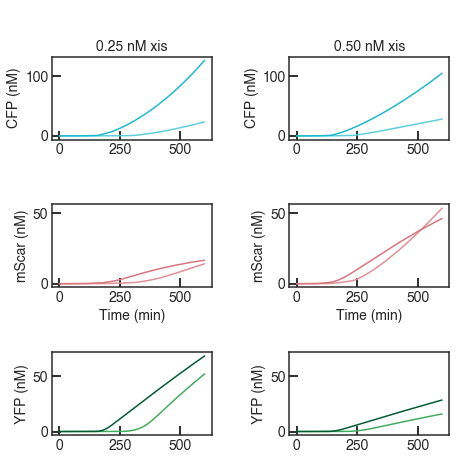

In [145]:
## Plot the results:
colorcfp = ['#01b3c7','#1abacc','#33c2d2','#4dc9d7','#66d1dd']
colormscar = ['#be1825','#c42f3a','#cb4650','#d15d66','#d8747c']
# coloryfp = ['#8b6a2b','#a27c32','#b98e39','#d0a040','#e8b248']
coloryfp = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
# coloryfp = ['#8b6a2b','#a27c32','#b98e39','#d0a040','#e8b248']
coloryfp = ['#41ab5d','#005a32']
# time_lim = (0,180)
# cfp_lim = (0,250)
# mScar_lim = (0,250)t
# yfp_lim = (0,70)
figsize = (7,7)
# fig, ax = plt.subplots(nrows = len(int_levels), ncols = len(exc_levels), figsize=figsize)
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
#     axi = fig.add_subplot(2,len(int_levels),index)
#     axe = fig.add_subplot(2,len(exc_levels),index+len(exc_levels))
#     axm = fig.add_subplot(len,len(exc_levels),index+len(exc_levels))
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
#         curr_ax = ax[exc_ind,int_ind]
        # curr_ax.plot(timepoints, simdata[(int_levels[int_ind] ,exc_levels[exc_ind],'cfp')],
                 # color='#2986cc')
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
#         curr_ax_twin = curr_ax.twinx()
#         curr_ax_twin.plot(timepoints, simdata[(int_levels[int_ind] ,exc_levels[exc_ind],'yfp')]
#                  ,color='#274E13', sharey = axy)
#         if index == 1:
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
#         else:
#             axc.set_title('%1.2f nM integrase' % (int_levels[int_ind]))        
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))
        # Integrase CFP labels:
#         for tl in curr_ax.get_yticklabels():
#             tl.set_color('#2986cc')
        # Excisionase mScar labels:
        # for tl in curr_ax.get_yticklabels():
        #     tl.set_color('#d8747c')
            
#         for tl in curr_ax_twin.get_yticklabels():
#             tl.set_color('#274E13')
            
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

    
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-sim.svg')

In [146]:
parameter_dict.keys()

dict_keys(['k_bpi', 'k_upi', 'K_txi', 'k_bri', 'k_uri', 'k_tli', 'a_i', 'd_i', 'k_int', 'a_r', 'd_r', 'a_e1', 'd_e1', 'k_exc', 'a_r1', 'd_r1', 'a_s2', 'd_s2', 'a_s1', 'd_s1', 'a_e2', 'd_e2', 'a_r2', 'd_r2', 'k_bpe', 'k_upe', 'k_txe', 'k_bre', 'k_ure', 'k_tle', 'k_bp', 'k_up', 'k_tx', 'k_br', 'k_ur', 'k_tl', 'd_bTi', 'd_uTi', 'd_Ti', 'd_bRTi', 'd_uRTi', 'd_RTi', 'd_bTe', 'd_uTe', 'd_Te', 'd_bRTe', 'd_uRTe', 'd_RTe', 'd_bT', 'd_uT', 'd_T', 'd_bRT', 'd_uRT', 'd_RT'])

### Sensitivity analysis

In [147]:
m = Model(sbml_filename = 'sbml_files/integrase_excisionase_txtl_resources_updated.xml')
# Set resource levels
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
m.set_species({"P": RNAP_total, "R": Ribosome_total, "Endo":Endonuclease_total})
m.set_params(parameter_dict)

In [43]:
list(m.get_species_dictionary().keys())[21]

'YFP'

C:\Users\apand\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\bioscrape\analysis.py:228: RuntimeWarning: invalid value encountered in true_divide
  SSM_normalized[:,j,i] = np.divide(SSM[:,j,i]*params_values[j], solutions[:,i])
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
C:\U

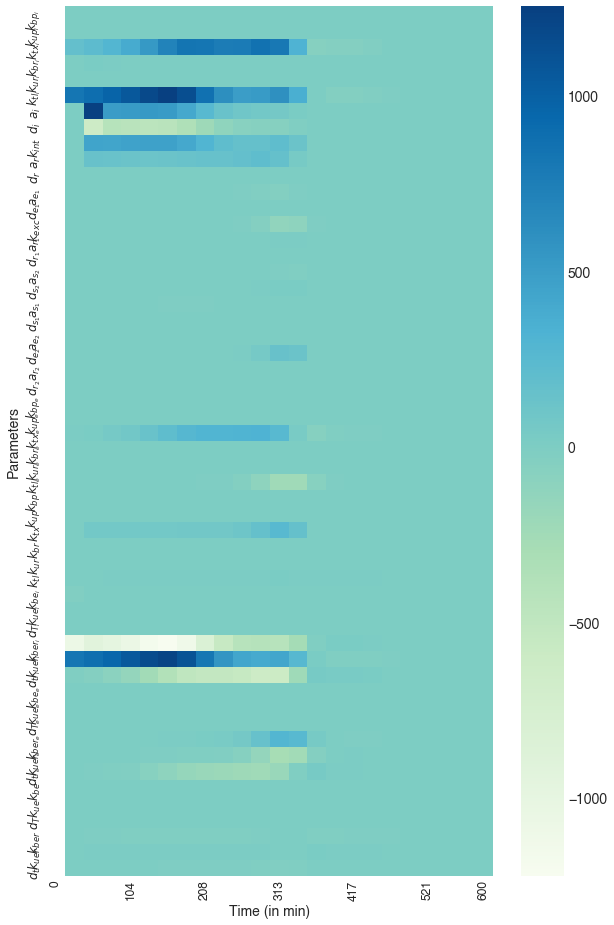

In [45]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
int_levels = [0.5]
exc_levels = [0.25]
rep_level = 0.5
# int_levels = [0.25,0.5,0.75,1.]
# rep_levels = [0.25,0.5,0.75,1.]
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (10,16)
fig, ax = plt.subplots(nrows = len(exc_levels), ncols= len(int_levels), figsize=figsize)
index = 1
params_names_latex = ['$k_{bp_i}$', '$k_{up_i}$', '$k_{tx_i}$', '$k_{br_i}$', '$k_{ur_i}$', '$k_{tl_i}$',
                      '$a_i$','$d_i$', '$k_{int}$', '$a_r$','$d_r$', '$a_{e_1}$', '$d_{e_1}$', '$k_{exc}$',
                      '$a_{r_1}$', '$d_{r_1}$', '$a_{s_2}$', '$d_{s_2}$', '$a_{s_1}$', '$d_{s_1}$',
                      '$a_{e_2}$', '$d_{e_2}$', '$a_{r_2}$', '$d_{r_2}$', '$k_{bp_e}$', '$k_{up_e}$',
                      '$k_{tx_e}$', '$k_{br_e}$', '$k_{ur_e}$', '$k_{tl_e}$', '$k_{bp}$', '$k_{up}$', '$k_{tx}$', 
                      '$k_{br}$', '$k_{ur}$', '$k_{tl}$','$k_{be_i}$', '$k_{ue_i}$', '$d_{T_i}$', '$k_{ber_i}$', '$k_{uer_i}$',
                      '$d_{tr_i}$','$k_{be_e}$', '$k_{ue_e}$', '$d_{T_e}$', '$k_{ber_e}$', '$k_{uer_e}$',
                      '$d_{tr_e}$','$k_{be}$', '$k_{ue}$', '$d_{T}$', '$k_{ber}$', '$k_{uer}$',
                      '$d_{tr}$']
for exc_ind in range(len(exc_levels)):
    exc_nm = exc_levels[exc_ind]
#     axc = fig.add_subplot(2,2,index)
#     axy = fig.add_subplot(2,2,index+2)
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_i": int_nm, "G_e": exc_nm, "U": rep_level})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,21].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
#         sn.heatmap(SSM[:,:,6].T, ax = ax[rep_ind][int_ind])
#         ax.set_title('Integrase plasmid:{0}, Reporter Plasmid:{1}'.format(int_nm, rep_nm))
#     if index == 1:
#         axc.set_yticklabels(m.get_param_list())
#         axy.set_yticklabels(m.get_param_list())
#     else:
#         axc.set_yticklabels([])
#         axy.set_yticklabels([])
#     axc.set_xticklabels(np.arange(0,600))
#     axy.set_xticklabels(np.round(timepoints,1))
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Parameters')
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=12, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=12, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
# bottom, top = ax[0].get_ylim()
# ax[0].set_ylim(bottom + 0.5, top - 0.5)# h.set_rotation(0)
_ = plt.savefig('outputs/excisionase-sensitivity-50-25-50.svg')
plt.show()

In [48]:
list(m.get_parameter_dictionary().keys())[35]

'k_tl'

# From CRNs to ODEs -- Model Reduction

With the above CRN, we can simulate the system dynamics as shown. Underlying the simulations, is an ordinary differential equation (ODE) that is integrated to generate the solutions for the system with time. For the CRN above, we have mass-action propensity reactions that are written into an SBML file with the corresponding reaction rate parameters. These are then integrated as ODEs by the simulator (bioscrape). The number of species in the CRN is equal to the number of state variables in the ODE. It is often the case that the values for the different reaction rate parameters are unknown and hard to infer because of limited number of measurments. Hence, we derive reduced-order ODE models with fewer number of parameters to improve our estimates of the "lumped" parameters given the measurements.


### The AutoReduce package can automatically compute reduced-order ODE models for biological system model in an SBML file.



## AutoReduce notation

The following notation would be helpful in setting up the model reduction problem. Let us assume that the state variables in the ODE model are called $x$, then we can write the dynamics of the system as:

$ \dot{x} = f(x, \theta)$

where $f(\cdot)$ is a nonlinear vector function that models the dynamics of the state variables $x$. The output variables of the system may be modeled as:

$ y = Cx$ 

where $y$ is the output vector and $C$ is the output matrix. Note that the shape of the $C$ matrix will be length of $y$ times the length of of $x$. 

With AutoReduce, we consider quasi-steady state approximations to derive reduced models. All reduced-order models are denoted by a $\hat{\cdot}$ to the variables. For example, $\hat{x}$ is the states of the reduced-order model. These are the so-called "slow states" of the model since we are interested in the dynamics of these states and we assume that the dynamics of the remaining states $x_c$ have been collapsed to algebraic relationships. The states $x_c$ are called the "fast states" since we assume these to be at quasi-steady state.

Note that with AutoReduce, all reduced models preserve the structure of the full model since transformations are not introduced in the model reduction procedure. 

# Model Reduction with AutoReduce

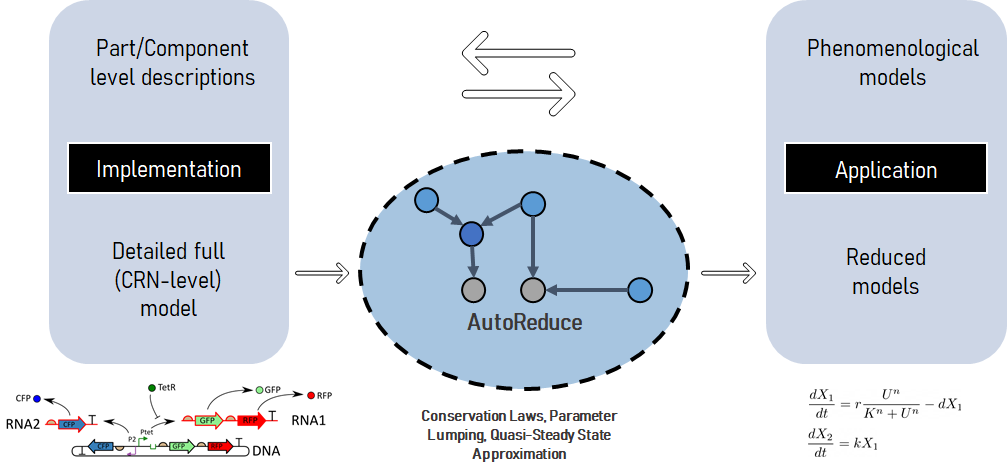

To get started with AutoReduce, we load a model using an SBML file:

In [1100]:
from autoreduce.converters import load_sbml
from autoreduce.system import System
from sympy import Symbol
import sympy

integrase_excisionase_system_context = load_sbml('sbml_files/integrase_excisionase_txtl_resources_updated.xml', 
                                                 outputs = ['Int', 'Exc','YFP'])

In [1101]:
integrase_excisionase_system_context.x

[G_i,
 P,
 T_i,
 Ci_1,
 R,
 Int,
 Ci_2,
 U,
 A,
 C_i,
 C_a,
 Exc,
 C_e,
 C_r,
 C_IE,
 G_e,
 T_e,
 Ce_1,
 Ce_2,
 T,
 C_1,
 YFP,
 C_2,
 Endo,
 C_ETi,
 C_ERTi,
 C_ETe,
 C_ERTe,
 C_E,
 C_RE]

In [1102]:
G_i,P,T_i,Ci_1,R,Int,Ci_2,U,A,C_i,C_a,Exc,C_e,C_r,C_ie,G_e,T_e,Ce_1,Ce_2,T,C_1,YFP,C_2,Endo,C_eti,C_erti,C_ete,C_erte,C_e,C_re = integrase_excisionase_system_context.x

## Model Reduction: Step 1 - Conservation Laws

For all binding and catalysis steps, we can usually derive conservation laws from the ODE of a CRN. To derive the reduced model on applying conservation laws, we simply need to call the `set_conservation_laws` function for the AutoReduce `System` object. To run this function, we need to define what the conserved quantities are and the states that we need to eliminate after we set the conservation laws to the model. We do this for the integrase_system example above where $R + C = R_{tot}$.

In [1103]:
crn_matrix = sympy.Matrix(integrase_excisionase_system_context.f)

In [1104]:
crn_matrix

Matrix([
[                                                                                                                                                                                                                                  Ci_1*K_txi + Ci_1*k_upi - G_i*P*k_bpi],
[                                                                                                                                                        -A*P*k_bp + C_1*k_tx + C_1*k_up + Ce_1*k_txe + Ce_1*k_upe + Ci_1*K_txi + Ci_1*k_upi - G_e*P*k_bpe - G_i*P*k_bpi],
[                                                                                                                                                                                      C_ETi*d_uTi + Ci_1*K_txi + Ci_2*k_tli + Ci_2*k_uri - Endo*T_i*d_bTi - R*T_i*k_bri],
[                                                                                                                                                                                             

In [1105]:
conserved_sets = []

First law:

In [1106]:
law1 = [integrase_excisionase_system_context.x[0],integrase_excisionase_system_context.x[3]]
conserved_sets.append(law1)
law1

[G_i, Ci_1]

In [1107]:
integrase_excisionase_system_context.f[0] + integrase_excisionase_system_context.f[3]

0

Second law:

In [1108]:
law2 = [integrase_excisionase_system_context.x[15],integrase_excisionase_system_context.x[17]]
conserved_sets.append(law2)
law2

[G_e, Ce_1]

In [1109]:
integrase_excisionase_system_context.f[15] + integrase_excisionase_system_context.f[17]

0

Third law:

In [1110]:
law3 = [integrase_excisionase_system_context.x[1], integrase_excisionase_system_context.x[3] \
+ integrase_excisionase_system_context.x[17],integrase_excisionase_system_context.x[20]]
conserved_sets.append(law3)
law3

[P, Ce_1 + Ci_1, C_1]

In [1111]:
integrase_excisionase_system_context.f[1] + integrase_excisionase_system_context.f[3] \
+ integrase_excisionase_system_context.f[17]+ integrase_excisionase_system_context.f[20]

0

Fourth law:

In [1112]:
law4 = [integrase_excisionase_system_context.x[4],integrase_excisionase_system_context.x[6] \
,integrase_excisionase_system_context.x[18],integrase_excisionase_system_context.x[22]\
,integrase_excisionase_system_context.x[-1],integrase_excisionase_system_context.x[-3]\
,integrase_excisionase_system_context.x[-5]]
conserved_sets.append(law4)
law4

[R, Ci_2, Ce_2, C_2, C_RE, C_ERTe, C_ERTi]

In [1113]:
integrase_excisionase_system_context.f[4] + integrase_excisionase_system_context.f[6] \
+ integrase_excisionase_system_context.f[18]+ integrase_excisionase_system_context.f[22]\
+ integrase_excisionase_system_context.f[-1]+ integrase_excisionase_system_context.f[-3]\
+ integrase_excisionase_system_context.f[-5]

0

Fifth law:

In [1114]:
law5 = [integrase_excisionase_system_context.x[23],integrase_excisionase_system_context.x[24] \
, integrase_excisionase_system_context.x[25],integrase_excisionase_system_context.x[26]\
, integrase_excisionase_system_context.x[27],integrase_excisionase_system_context.x[28]\
, integrase_excisionase_system_context.x[29]]
conserved_sets.append(law5)
law5

[Endo, C_ETi, C_ERTi, C_ETe, C_ERTe, C_E, C_RE]

In [1115]:
integrase_excisionase_system_context.f[23] + integrase_excisionase_system_context.f[24] \
+ integrase_excisionase_system_context.f[25]+ integrase_excisionase_system_context.f[26]\
+ integrase_excisionase_system_context.f[27]+ integrase_excisionase_system_context.f[28]\
+ integrase_excisionase_system_context.f[29]

0

Sixth law:

In [1116]:
law6 = [integrase_excisionase_system_context.x[7] \
, integrase_excisionase_system_context.x[8], integrase_excisionase_system_context.x[9]\
, integrase_excisionase_system_context.x[10], integrase_excisionase_system_context.x[12]\
, integrase_excisionase_system_context.x[13], integrase_excisionase_system_context.x[20]]
conserved_sets.append(law6)
law6

[U, A, C_i, C_a, C_e, C_r, C_1]

In [1117]:
integrase_excisionase_system_context.f[7] \
+ integrase_excisionase_system_context.f[8]+ integrase_excisionase_system_context.f[9]\
+ integrase_excisionase_system_context.f[10]+ integrase_excisionase_system_context.f[12]\
+ integrase_excisionase_system_context.f[13]+ integrase_excisionase_system_context.f[20]

0

In [1118]:
conserved_sets

[[G_i, Ci_1],
 [G_e, Ce_1],
 [P, Ce_1 + Ci_1, C_1],
 [R, Ci_2, Ce_2, C_2, C_RE, C_ERTe, C_ERTi],
 [Endo, C_ETi, C_ERTi, C_ETe, C_ERTe, C_E, C_RE],
 [U, A, C_i, C_a, C_e, C_r, C_1]]

In [1119]:
# Now set the conservation laws, simulate, and generate one figure. 
total_quantities = {'Gi_tot':0, 'Ge_tot':0, 'P_tot':0, 'R_tot':0, 'E_tot':0, 'G_tot':0}
states_to_eliminate = [G_i, G_e, P, R, Endo, U]
conserved_model = integrase_excisionase_system_context.solve_conservation_laws(total_quantities=total_quantities, 
                                                             conserved_sets=conserved_sets,
                                                             states_to_eliminate=states_to_eliminate)

Found conservation laws: [Ci_1 + G_i - Gi_tot, Ce_1 + G_e - Ge_tot, C_1 + Ce_1 + Ci_1 + P - P_tot, C_2 + C_ERTe + C_ERTi + C_RE + Ce_2 + Ci_2 + R - R_tot, C_E + C_ERTe + C_ERTi + C_ETe + C_ETi + C_RE - E_tot + Endo, A + C_1 + C_a + C_e + C_i + C_r - G_tot + U]


In [1120]:
conserved_ode = sympy.Matrix(conserved_model.f)
conserved_ode

Matrix([
[                                            C_ETi*d_uTi + Ci_1*K_txi + Ci_2*k_tli + Ci_2*k_uri - T_i*d_bTi*(-C_E - C_ERTe - C_ERTi - C_ETe - C_ETi - C_RE + E_tot) - T_i*k_bri*(-C_2 - C_ERTe - C_ERTi - C_RE - Ce_2 - Ci_2 + R_tot)],
[                                                                                                                                                      -Ci_1*K_txi - Ci_1*k_upi + k_bpi*(-Ci_1 + Gi_tot)*(-C_1 - Ce_1 - Ci_1 + P_tot)],
[-4.0*A*Int**4*d_r + C_IE*d_s1 + 4.0*C_a*a_r + 4.0*C_i*d_i + 4.0*C_r*a_r1 + Ci_2*k_tli - 4.0*Exc**4*Int**4*d_r1*(-A - C_1 - C_a - C_e - C_i - C_r + G_tot) - Exc*Int*a_s1 - 4.0*Int**4*a_i*(-A - C_1 - C_a - C_e - C_i - C_r + G_tot)],
[                                                     C_ERTi*d_uRTi - Ci_2*d_bRTi*(-C_E - C_ERTe - C_ERTi - C_ETe - C_ETi - C_RE + E_tot) - Ci_2*k_tli - Ci_2*k_uri + T_i*k_bri*(-C_2 - C_ERTe - C_ERTi - C_RE - Ce_2 - Ci_2 + R_tot)],
[                                                              

Simulate 

In [1121]:
from autoreduce.utils import get_ODE
import numpy as np
timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(conserved_model, timepoints=timepoints)

In [1122]:
len(ode_reduced.params)

60

In [1123]:
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
ode_reduced.params_values = list(parameter_dict.values()) + [0, 0, RNAP_total, Ribosome_total, Endonuclease_total, 0]

In [1124]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        ode_reduced.params_values[-6] = int_nm #Gi_tot
        ode_reduced.params_values[-5] = exc_nm #Ge_tot
        ode_reduced.params_values[-1] = rep_level #G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result[2,:]
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result[7,:]
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result[16,:]

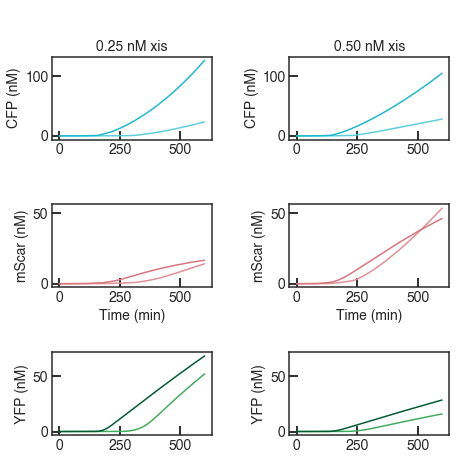

In [1125]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']
figsize = (7,7)

fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

    
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-sim-conserved.svg')

## Model Reduction: Step 2 - Time-Scale Separation

To further reduce the system model, we can use quasi-steady state approximation (QSSA) assumptions. The common practice is to assume certain states at quasi-steady state and derive the resulting reduced models by hand. However, AutoReduce automates the QSSA procedure so that it is possible to verify whether given assumptions of QSSA are valid or not. The automated QSSA also allows us to compute different reduced models and compare them in different parameter regimes. 


In [1126]:
T_i,Ci_1,Int,Ci_2,A,C_i,C_a,Exc,C_e,C_r,C_IE,T_e,\
Ce_1,Ce_2,T,C_1,YFP,C_2,C_ETi,C_ERTi,C_ETe,C_ERTe,C_E,C_RE = conserved_model.x

In [1127]:
reduced_model, collapsed_model = conserved_model.solve_timescale_separation(slow_states = [Ci_1,Int,Ci_2,
                                                                                           A,C_i,C_a,Exc,C_e,
                                                                                           C_r,C_IE,Ce_1,
                                                                                           Ce_2,T,C_1,YFP,C_2,
                                                                                           C_ETi,C_ERTi,C_ETe,
                                                                                           C_ERTe,C_E,C_RE])

Successful time-scale separation solution obtained with states: [Ci_1, Int, Ci_2, A, C_i, C_a, Exc, C_e, C_r, C_IE, Ce_1, Ce_2, T, C_1, YFP, C_2, C_ETi, C_ERTi, C_ETe, C_ERTe, C_E, C_RE]!


In [1157]:
# Uncomment if you want to try to reduce further 
from autoreduce.utils import get_reducible
reduce_reduced_model = get_reducible(reduced_model)

reduced_model, collapsed_model = reduce_reduced_model.solve_timescale_separation(slow_states = [Int,Ci_2,
                                                                                           A,C_a,Exc,C_e,
                                                                                           C_r,C_IE,Ce_1,
                                                                                           Ce_2,C_1,YFP,C_2,
                                                                                           C_ERTi,C_ETe,
                                                                                           C_ERTe,C_E,C_RE])

KeyboardInterrupt: 

In [281]:
# Uncomment if you want to try to reduce further 
from autoreduce.utils import get_reducible
reduce_reduced_model2 = get_reducible(reduced_model)

reduced_model2, collapsed_model2 = reduce_reduced_model2.solve_timescale_separation(slow_states = [Ci_1,Int,Ci_2,
                                                                                           A,Exc,C_e,
                                                                                           C_r,C_IE,Ce_1,
                                                                                           Ce_2,C_1,YFP,C_2,
                                                                                           C_ERTi,
                                                                                           C_ERTe,C_RE])


KeyboardInterrupt



In [1144]:
len(reduced_model.x)

19

In [1145]:
from autoreduce.utils import get_ODE
import numpy as np
timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)

In [1146]:
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
ode_reduced.params_values = list(parameter_dict.values()) + [0, 0, RNAP_total, Ribosome_total, Endonuclease_total, 0]

In [1152]:
ode_reduced.x[11]

YFP

In [1153]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        ode_reduced.params_values[-6] = int_nm #Gi_tot
        ode_reduced.params_values[-5] = exc_nm #Ge_tot
        ode_reduced.params_values[-1] = rep_level #G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result[0,:]
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result[4,:]
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result[11,:]

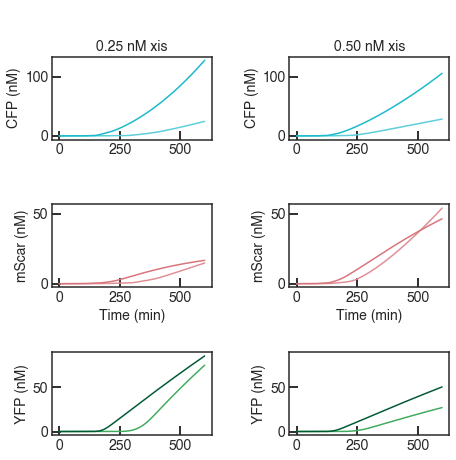

In [1154]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']
figsize = (7,7)
plt.close()
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

    
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-sim-qssa.svg')

## Model without context

In [1159]:
class SimpleExcisionaseFlipper(Mechanism):
    """Mechanism for the simple excisionase flipping. 
    Excisionase binds to integrase then to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase and integrase unbind.
    Other kinds of interactions are not allowed.
    """
    def __init__(self, name: str="simple-excisionase-flipper", 
                 mechanism_type: str="simple-excisionase-flipper", **keywords):
        """Initializes a SimpleExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: simple-excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: simple-excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
        integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
        self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex, integrase_excisionase_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        if integrase_excisionase_complex is None:
            if self.integrase_excisionase_complex is None:
                raise ValueError('The integrase_excisionase_species is not set for mechanism {0}'.format(self.name))
            integrase_excisionase_complex = self.integrase_excisionase_complex
        # First set of excisionase action
#         list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
#         excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                 [complex_species],
#                                                                 k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
        integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
                                                             [integrase_excisionase_complex],
                                                             k_forward = a_s1, k_reverse = d_s1)
        
#         list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
#         excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                  [flipped_complex],
#                                                                  k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
        list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
        int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [complex_species],
                                                                 k_forward = a_e2, k_reverse = d_e2)
        list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
        int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [flipping_reaction, excisionase_unbinding_reaction,
                     integrase_excisionase_bind, int_exc_binding_curr_dna,
                     int_exc_binding_rev_dna]
        return reactions

In [288]:
parameters_simple = {("gene_expression", "P_int", "kexpress"):1,
                     ("gene_expression", "P_exc", "kexpress"):1,
                     ("gene_expression", "P_A", "kexpress"):1}
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 2)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 50)
# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 1e4)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 1e-4)
# Integrase flipping rate
k_int = ParameterEntry("k_int", 5)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

# Excisionase binding to Integrase bound attL_attR DNA
a_e1 = ParameterEntry("a_e1", 20) # formerly a_e
# Excisionase unbinding Integrase bound attL_attR DNA
d_e1 = ParameterEntry("d_e1", 5) # formerly d_e
# Integrase-Excisionase complex binding attL_attR DNA
a_e2 = ParameterEntry("a_e2", 50) # formerley a1
# Integrase-Excisionase complex unbinding attL_attR DNA
d_e2 = ParameterEntry("d_e2", 2) #formerly d1

# Excisionase flipping rate
k_exc = ParameterEntry("k_exc", 5)
# Integrase binding to Excisionase
a_s1 = ParameterEntry("a_s1", 10) # formerly k1
# Integrase unbinding Excisionase
d_s1 = ParameterEntry("d_s1", 1) # formerly k2
# Integrase-Excisionase complex binding attP_attB-4I 
a_s2 = ParameterEntry("a_s2", 2) # formerly a2
# Integrase-Excisionase complex unbinding attP_attB-4I
d_s2 = ParameterEntry("d_s2", 5e-1) #formerly d2
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB, I, and E
a_r1 = ParameterEntry("a_r1", 10) # formerly a_r1
# Binding of attP_attB, I, and E to form Integrase-Excisionase-attP_attB complex 
d_r1 = ParameterEntry("d_r1", 1e4) #formerly d_r1
# Binding of attP_attB and I_E complex to form Integrase-Excisionase-attP_attB complex 
a_r2 = ParameterEntry("a_r2", 10)
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB and I_E
d_r2 = ParameterEntry("d_r2", 1)

parameters_excisionase = {'a_e1':a_e1, 'd_e1':d_e1, 'k_exc':k_exc, 'a_r1':a_r1, 'd_r1':d_r1,
                          'a_r2':a_r2, 'd_r2':d_r2, 'a_e2':a_e2, 'd_e2':d_e2, 'a_s1':a_s1, 'd_s1':d_s1,
                          'a_s2':a_s2, 'd_s2':d_s2}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G_exc = DNAassembly("G_exc", promoter = "P_exc", rbs = "RBS2", transcript = "T_exc", protein = "Exc")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS3", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                      cooperativity = 4, parameter_dict = parameters_integrase,
                      mechanism = I0_mech)
E0_mech = SimpleExcisionaseFlipper()
E = ExcisionaseSite(excisionase = G_exc.protein, integrase_site = I0, 
                    curr_dna = G.dna, reversed_dna = U, cooperativity = 4, 
                    parameter_dict = parameters_excisionase,
                    mechanism = E0_mech)
M = ExpressionExtract("Gene_Expr_Mix", components = [G_int, I0, E, G_exc, G], 
                 parameters = parameters_simple)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("sbml_files/integrase_excisionase_simple.xml")

True

In [289]:
CRN

Species = dna_G_int, protein_Int, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_4x_, complex_dna_attL_attR_protein_Int_4x_, protein_Exc, complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_, complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_, complex_protein_Exc_protein_Int_, dna_G_exc, protein_Y
Reactions = [
	dna[G_int] --> dna[G_int]+protein[Int]
	4protein[Int]+dna[attP_attB] <--> complex[dna[attP_attB]:4x_protein[Int]]
	complex[dna[attP_attB]:4x_protein[Int]] --> complex[dna[attL_attR]:4x_protein[Int]]
	complex[dna[attL_attR]:4x_protein[Int]] <--> 4protein[Int]+dna[attL_attR]
	complex[complex[dna[attL_attR]:4x_protein[Int]]:4x_protein[Exc]] --> complex[complex[dna[attP_attB]:4x_protein[Int]]:4x_protein[Exc]]
	complex[complex[dna[attP_attB]:4x_protein[Int]]:4x_protein[Exc]] <--> 4protein[Exc]+4protein[Int]+dna[attP_attB]
	protein[Int]+protein[Exc] <--> complex[protein[Exc]:protein[Int]]
	4complex[protein[Exc]:protein[Int]]+dna[attL_attR] <--> co

### Edit SBML to simplify names

In [290]:
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML('sbml_files/integrase_excisionase_simple.xml')
model = document.getModel()

In [293]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Parameter:
        print(element.getId())

kexpress_P_int_gene_expression
a_i__
d_i__
k_int__
a_r__
d_r__
k_exc__
a_r1__
d_r1__
a_s1__
d_s1__
a_e2__
d_e2__
a_r2__
d_r2__
kexpress_P_exc_gene_expression
kexpress_P_A_gene_expression


In [294]:
old_ids = ['dna_G_int',
'protein_Int',
'dna_attP_attB',
'dna_attL_attR',
'complex_dna_attP_attB_protein_Int_4x_',
'complex_dna_attL_attR_protein_Int_4x_',
'protein_Exc',
'complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_',
'complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_',
'complex_protein_Exc_protein_Int_',
'dna_G_exc',
'protein_Y',
'kexpress_P_int_gene_expression',
'a_i__',
'd_i__',
'k_int__',
'a_r__',
'd_r__',
'k_exc__',
'a_r1__',
'd_r1__',
'a_s1__',
'd_s1__',
'a_e2__',
'd_e2__',
'a_r2__',
'd_r2__',
'kexpress_P_exc_gene_expression',
'kexpress_P_A_gene_expression']


new_ids = ['G_I',
'Int',
'U',
'A',
'C_I',
'C_A',
'Exc',
'C_E',
'C_R',
'C_IE',
'G_E',
'YFP',
'k_i',
'a_i',
'd_i',
'k_int',
'a_r',
'd_r',
'k_exc',
'a_r1',
'd_r1',
'a_s1',
'd_s1',
'a_e2',
'd_e2',
'a_r2',
'd_r2',
'k_e',
'k']
renameSIds(document, old_ids, new_ids, debug = True)
writer = libsbml.SBMLWriter()
writer.writeSBML(document, 'sbml_files/integrase_excisionase_simple_updated.xml')

True

Simulate it:

In [747]:
m = Model(sbml_filename = 'sbml_files/integrase_excisionase_simple_updated.xml')

In [748]:
m.get_parameter_dictionary()

{'k_i': 1.0,
 'a_i': 2.0,
 'd_i': 50.0,
 'k_int': 5.0,
 'a_r': 10000.0,
 'd_r': 0.0001,
 'k_exc': 5.0,
 'a_r1': 10.0,
 'd_r1': 10000.0,
 'a_s1': 10.0,
 'd_s1': 1.0,
 'a_e2': 50.0,
 'd_e2': 2.0,
 'a_r2': 10.0,
 'd_r2': 1.0,
 'k_e': 1.0,
 'k': 1.0}

In [749]:
parameter_dict = {'k_i': 0.2, # Integrase expression rate
 'a_i': 0.3, # Binding of integrase to attP-attB
 'd_i': 500.0, # Unbinding of integrase to attP-attB
 'k_int': 0.5, # Integrase flip rate
 'a_r': 1, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r': 1e-3, # Binding rate of integrase to attL_attR site 
 'k_exc': 0.05, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
 'a_r1': 0.02, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
 'd_r1': 0.0007, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
 'a_s1': 0.02, # Binding rate of integrase to excisionase
 'd_s1': 10, # Unbinding rate of integrase to excisionase
 'a_e2': 0.05, # Binding rate of integrase-excisionase complex to attL_attR DNA
 'd_e2': 0.02, # Unbinding rate of integrase-excisionase complex to attL_attR DNA
 'a_r2': 0.02, # Binding rate of integrase-excisionase complex to attP_attB complex 
 'd_r2': 0.01, # Unbinding rate of integrase-excisionase complex and attP_attB complex from attP-attB-I-E
 'k_e': 0.3, # Excisionase expression rate
 'k': 50 # YFP expression rate
}
m.set_params(parameter_dict)

In [750]:
timepoints = np.linspace(0,600,600)
simdata = {}
# int_levels = [0,0.5,1,1.5,2]
# exc_levels = [0,0.25,0.5,0.75,1]
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
# rep_levels = [0,0.25,0.5,0.75,1.]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        m.set_species({"G_I": int_nm, "G_E": exc_nm, "U": rep_level})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result['Int']
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result['Exc']
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result['YFP']

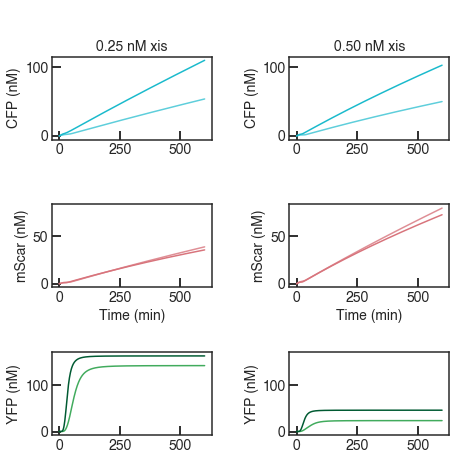

In [751]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']

figsize = (7,7)
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))  
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-simple-sim.svg')

### Sensitivity analysis

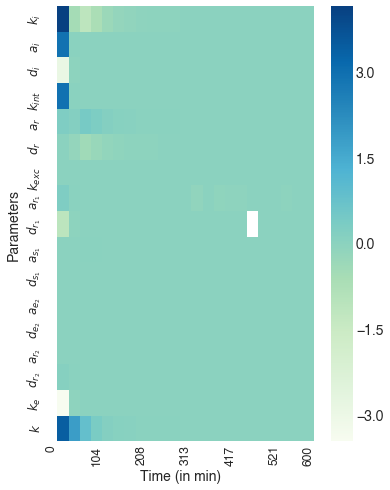

In [628]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
# m = Model(sbml_filename = "integrase_excisionase_simple_updated.xml")
# parameter_dict = {'k_i': 0.2, # Integrase expression rate
#  'a_i': 0.3, # Binding of integrase to attP-attB
#  'd_i': 500.0, # Unbinding of integrase to attP-attB
#  'k_int': 0.5, # Integrase flip rate
#  'a_r': 1, # Unbinding rate of integrase from attL_attR-integrase bound complex
#  'd_r': 1e-3, # Binding rate of integrase to attL_attR site 
#  'k_exc': 0.5, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
#  'a_r1': 0.02, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
#  'd_r1': 0.07, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
#  'a_s1': 0.02, # Binding rate of integrase to excisionase
#  'd_s1': 10, # Unbinding rate of integrase to excisionase
#  'a_e2': 0.05, # Binding rate of integrase-excisionase complex to attL_attR DNA
#  'd_e2': 0.02, # Unbinding rate of integrase-excisionase complex to attL_attR DNA
#  'a_r2': 0.02, # Binding rate of integrase-excisionase complex to attP_attB complex 
#  'd_r2': 0.01, # Unbinding rate of integrase-excisionase complex and attP_attB complex from attP-attB-I-E
#  'k_e': 0.3, # Excisionase expression rate
#  'k': 25 # YFP expression rate
# }
# m.set_params(parameter_dict)
int_levels = [0.5]
exc_levels = [0.25]
rep_level = 0.5
# int_levels = [0.25,0.5,0.75,1.]
# rep_levels = [0.25,0.5,0.75,1.]
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (6,8)
fig, ax = plt.subplots(nrows = len(exc_levels), ncols= len(int_levels), figsize=figsize)
index = 1
params_names_latex = ['$k_i$','$a_i$','$d_i$','$k_{int}$','$a_r$','$d_r$',
                      '$k_{exc}$', '$a_{r_1}$', 
                      '$d_{r_1}$',
                      '$a_{s_1}$', '$d_{s_1}$', '$a_{e_2}$', 
                      '$d_{e_2}$', '$a_{r_2}$', '$d_{r_2}$', '$k_e$', '$k$']
for exc_ind in range(len(exc_levels)):
    exc_nm = exc_levels[exc_ind]
#     axc = fig.add_subplot(2,2,index)
#     axy = fig.add_subplot(2,2,index+2)
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_I": int_nm, "G_E": exc_nm, "U": rep_level})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,-1].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=12, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=12, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
# bottom, top = ax[0].get_ylim()
# ax[0].set_ylim(bottom + 0.5, top - 0.5)# h.set_rotation(0)
# _ = plt.savefig('outputs/xis-sens-simple-50-25-50.svg')
plt.show()

In [752]:
m.get_parameter_dictionary()

{'k_i': 0.2,
 'a_i': 0.3,
 'd_i': 500.0,
 'k_int': 0.5,
 'a_r': 1.0,
 'd_r': 0.001,
 'k_exc': 0.05,
 'a_r1': 0.02,
 'd_r1': 0.0007,
 'a_s1': 0.02,
 'd_s1': 10.0,
 'a_e2': 0.05,
 'd_e2': 0.02,
 'a_r2': 0.02,
 'd_r2': 0.01,
 'k_e': 0.3,
 'k': 50.0}

In [898]:
m.write_sbml_model('sbml_files/integrase_excisionase_simple_updated.xml')

True

### Model reduction for model without context

In [944]:
from autoreduce.converters import load_sbml
from autoreduce.system import System
from sympy import Symbol
import sympy

int_xis_system = load_sbml('sbml_files/integrase_excisionase_simple_updated.xml', outputs = ['Int', 'YFP', 'Exc'])

In [945]:
int_xis_system.x

[A, C_A, C_E, C_I, C_IE, C_R, Exc, G_E, G_I, Int, U, YFP]

State Variables:

In [946]:
A, C_A, C_E, C_I, C_IE, C_R, Exc, G_E, G_I, Int, U, YFP = int_xis_system.x

Nonlinear Dynamics (Symbolic ODE):

In [947]:
int_xis_system.f

[-A*C_IE**4*a_e2 - A*Int**4*d_r + C_A*a_r + C_E*d_e2,
 A*Int**4*d_r - C_A*a_r + C_I*k_int,
 A*C_IE**4*a_e2 - C_E*d_e2 - C_E*k_exc,
 -C_I*d_i - C_I*k_int + Int**4*U*a_i,
 -4.0*A*C_IE**4*a_e2 + 4.0*C_E*d_e2 - 4.0*C_IE**4*U*a_r2 - C_IE*d_s1 + 4.0*C_R*d_r2 + Exc*Int*a_s1,
 C_E*k_exc + C_IE**4*U*a_r2 - C_R*a_r1 - C_R*d_r2 + Exc**4*Int**4*U*d_r1,
 C_IE*d_s1 + 4.0*C_R*a_r1 - 4.0*Exc**4*Int**4*U*d_r1 - Exc*Int*a_s1 + G_E*k_e,
 0,
 0,
 -4.0*A*Int**4*d_r + 4.0*C_A*a_r + 4.0*C_I*d_i + C_IE*d_s1 + 4.0*C_R*a_r1 - 4.0*Exc**4*Int**4*U*d_r1 - Exc*Int*a_s1 + G_I*k_i - 4.0*Int**4*U*a_i,
 C_I*d_i - C_IE**4*U*a_r2 + C_R*a_r1 + C_R*d_r2 - Exc**4*Int**4*U*d_r1 - Int**4*U*a_i,
 A*k]

Conservation laws:

In [948]:
conservation_laws = int_xis_system.get_conservation_laws(num_conservation_laws = 8, debug = True)

In [949]:
conservation_laws

[[A, C_A, C_E, C_I, C_R, U]]

In [950]:
G_tot = Symbol("G_tot")
int_xis_system.params.append(G_tot)
int_xis_system.params_values.append(0)

In [951]:
states_to_eliminate = [U]
# f_cons = integrase_system.set_conservation_laws(conserved_quantities, states_to_eliminate)
assumed_conservation_law = [U+C_I+C_R-G_tot]
f_cons = int_xis_system.set_conservation_laws(assumed_conservation_law, states_to_eliminate)

In [952]:
sympy.Matrix(int_xis_system.x)

Matrix([
[   A],
[ C_A],
[ C_E],
[ C_I],
[C_IE],
[ C_R],
[ Exc],
[ G_E],
[ G_I],
[ Int],
[ YFP]])

QSSA

In [953]:
reduced_model, collapsed_model = int_xis_system.solve_timescale_separation(slow_states = [G_I, Int, A,
                                                                                          Exc, C_E, C_R, C_IE,
                                                                                          G_E, YFP])

Successful time-scale separation solution obtained with states: [G_I, Int, A, Exc, C_E, C_R, C_IE, G_E, YFP]!


In [954]:
reducible_model = get_reducible(reduced_model)
reduced_model, collapsed_model = reducible_model.solve_timescale_separation(slow_states = [G_I, Int, A,
                                                                                          Exc,C_IE,
                                                                                          G_E, YFP])

Successful time-scale separation solution obtained with states: [G_I, Int, A, Exc, C_IE, G_E, YFP]!


In [955]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Reduced model dynamics:

In [956]:
reduced_model.x

[G_I, Int, A, Exc, C_IE, G_E, YFP]

In [957]:
reduced_model.f[5]

0

In [958]:
reduced_model.f[1]

1.0*(4.0*A*C_IE**4*Exc**4*Int**4*a_e2*d_i*d_r1*k_exc + 4.0*A*C_IE**4*Exc**4*Int**4*a_e2*d_r1*k_exc*k_int + 4.0*A*C_IE**4*Int**4*a_e2*a_i*a_r1*k_exc + 4.0*A*C_IE**4*a_e2*a_r1*d_i*k_exc + 4.0*A*C_IE**4*a_e2*a_r1*k_exc*k_int + 1.0*C_IE**5*a_r2*d_e2*d_i*d_s1 + 1.0*C_IE**5*a_r2*d_e2*d_s1*k_int + 1.0*C_IE**5*a_r2*d_i*d_s1*k_exc + 1.0*C_IE**5*a_r2*d_s1*k_exc*k_int - 1.0*C_IE**4*Exc*Int*a_r2*a_s1*d_e2*d_i - 1.0*C_IE**4*Exc*Int*a_r2*a_s1*d_e2*k_int - 1.0*C_IE**4*Exc*Int*a_r2*a_s1*d_i*k_exc - 1.0*C_IE**4*Exc*Int*a_r2*a_s1*k_exc*k_int + 1.0*C_IE**4*G_I*a_r2*d_e2*d_i*k_i + 1.0*C_IE**4*G_I*a_r2*d_e2*k_i*k_int + 1.0*C_IE**4*G_I*a_r2*d_i*k_exc*k_i + 1.0*C_IE**4*G_I*a_r2*k_exc*k_i*k_int + 4.0*C_IE**4*G_tot*a_r1*a_r2*d_e2*d_i + 4.0*C_IE**4*G_tot*a_r1*a_r2*d_e2*k_int + 4.0*C_IE**4*G_tot*a_r1*a_r2*d_i*k_exc + 4.0*C_IE**4*G_tot*a_r1*a_r2*k_exc*k_int + 1.0*C_IE*Exc**4*Int**4*d_e2*d_i*d_r1*d_s1 + 1.0*C_IE*Exc**4*Int**4*d_e2*d_r1*d_s1*k_int + 1.0*C_IE*Exc**4*Int**4*d_i*d_r1*d_s1*k_exc + 1.0*C_IE*Exc**4*Int**

In [959]:
reduced_model.f[2]

(-A*C_IE**8*a_e2*a_r2*d_i*k_exc - A*C_IE**8*a_e2*a_r2*k_exc*k_int - A*C_IE**4*Exc**4*Int**4*a_e2*d_i*d_r1*k_exc - A*C_IE**4*Exc**4*Int**4*a_e2*d_r1*k_exc*k_int - A*C_IE**4*Int**4*a_e2*a_i*a_r1*k_exc - A*C_IE**4*Int**4*a_e2*a_i*d_r2*k_exc - A*C_IE**4*Int**4*a_e2*a_i*k_exc*k_int - A*C_IE**4*a_e2*a_r1*d_i*k_exc - A*C_IE**4*a_e2*a_r1*k_exc*k_int - A*C_IE**4*a_e2*d_i*d_r2*k_exc - A*C_IE**4*a_e2*d_r2*k_exc*k_int + G_tot*Int**4*a_i*a_r1*d_e2*k_int + G_tot*Int**4*a_i*a_r1*k_exc*k_int + G_tot*Int**4*a_i*d_e2*d_r2*k_int + G_tot*Int**4*a_i*d_r2*k_exc*k_int)/(C_IE**4*a_r2*d_e2*d_i + C_IE**4*a_r2*d_e2*k_int + C_IE**4*a_r2*d_i*k_exc + C_IE**4*a_r2*k_exc*k_int + Exc**4*Int**4*d_e2*d_i*d_r1 + Exc**4*Int**4*d_e2*d_r1*k_int + Exc**4*Int**4*d_i*d_r1*k_exc + Exc**4*Int**4*d_r1*k_exc*k_int + Int**4*a_i*a_r1*d_e2 + Int**4*a_i*a_r1*k_exc + Int**4*a_i*d_e2*d_r2 + Int**4*a_i*d_r2*k_exc + a_r1*d_e2*d_i + a_r1*d_e2*k_int + a_r1*d_i*k_exc + a_r1*k_exc*k_int + d_e2*d_i*d_r2 + d_e2*d_r2*k_int + d_i*d_r2*k_exc + d_r

In [960]:
from autoreduce.utils import get_ODE
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)

In [961]:
parameter_dict = {'k_i': 0.2, # Integrase expression rate
 'a_i': 0.3, # Binding of integrase to attP-attB
 'd_i': 500.0, # Unbinding of integrase to attP-attB
 'k_int': 0.5, # Integrase flip rate
 'a_r': 1, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r': 1e-3, # Binding rate of integrase to attL_attR site 
 'k_exc': 0.05, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
 'a_r1': 0.02, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
 'd_r1': 0.0007, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
 'a_s1': 0.02, # Binding rate of integrase to excisionase
 'd_s1': 10, # Unbinding rate of integrase to excisionase
 'a_e2': 0.05, # Binding rate of integrase-excisionase complex to attL_attR DNA
 'd_e2': 0.02, # Unbinding rate of integrase-excisionase complex to attL_attR DNA
 'a_r2': 0.02, # Binding rate of integrase-excisionase complex to attP_attB complex 
 'd_r2': 0.01, # Unbinding rate of integrase-excisionase complex and attP_attB complex from attP-attB-I-E
 'k_e': 0.3, # Excisionase expression rate
 'k': 10 # YFP expression rate
}
for key,val in parameter_dict.items():
    ind = ode_reduced.params.index(Symbol(key))
    ode_reduced.params_values[ind] = val

In [962]:
ode_reduced.x[6]

YFP

Same initial conditions as for the full model:

In [963]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        ode_reduced.x_init[0] = int_nm #Gi_tot
        ode_reduced.x_init[5] = exc_nm #Ge_tot
        ode_reduced.params_values[-1] = rep_level #G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result[1,:]
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result[3,:]
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result[6,:]

Plotting code (same as before):

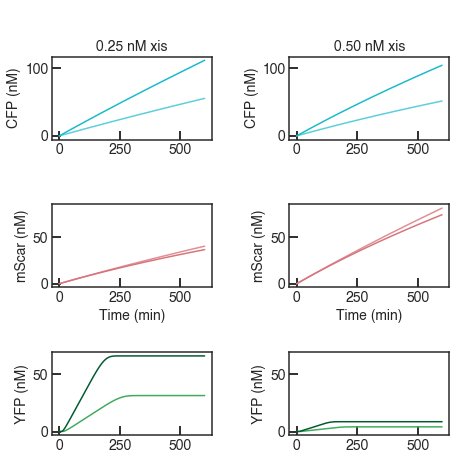

In [964]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']
figsize = (7,7)
plt.close()
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

    
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-sim-minimal.svg')

Write to SBML:

Convert parameter to empty species to give initial conditions to parameter identification process

In [982]:
import copy
save_reduced_model = copy.deepcopy(reduced_model)
# reduced_model = save_reduced_model

In [988]:
reduced_model.params.remove(G_tot)
reduced_model.params_values.pop(-1)
reduced_model.x.append(G_tot)
reduced_model.x_init.append(0)
reduced_model.f.append(Symbol(str(0)))

In [991]:
reduced_model.write_sbml("sbml_files/int-xis-minimal.xml")

<SBMLDocument>

Load SBML to verify:

In [992]:
m = Model(sbml_filename = "sbml_files/int-xis-minimal.xml")

In [994]:
m.get_species_dictionary()

{'G_I': 1.0,
 'Int': 0.0,
 'A': 0.0,
 'Exc': 0.0,
 'C_IE': 0.0,
 'G_E': 0.5,
 'YFP': 0.0,
 'G_tot': 0.0}

### Sensitivity analysis of the minimal model to guide parameter identification

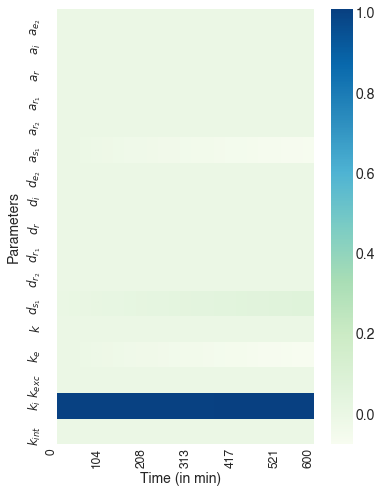

In [999]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
m = Model(sbml_filename = "sbml_files/int-xis-minimal.xml")
int_levels = [0.5]
exc_levels = [0.25]
rep_level = 0.5
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (6,8)
fig, ax = plt.subplots(nrows = len(exc_levels), ncols= len(int_levels), figsize=figsize)
index = 1
params_names_latex = ['$a_{e_2}$','$a_i$','$a_r$','$a_{r_1}$','$a_{r_2}$',
                      '$a_{s_1}$', '$d_{e_2}$','$d_i$','$d_r$',  
                      '$d_{r_1}$','$d_{r_2}$',
                      '$d_{s_1}$', '$k$',
                      '$k_e$','$k_{exc}$','$k_i$', '$k_{int}$']
for exc_ind in range(len(exc_levels)):
    exc_nm = exc_levels[exc_ind]
#     axc = fig.add_subplot(2,2,index)
#     axy = fig.add_subplot(2,2,index+2)
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_I": int_nm, "G_E": exc_nm, "G_tot": rep_level})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,1].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=12, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=12, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
# bottom, top = ax[0].get_ylim()
# ax[0].set_ylim(bottom + 0.5, top - 0.5)# h.set_rotation(0)
# _ = plt.savefig('outputs/xis-sens-minimal-cfp.svg')
plt.show()

## Minimal model 2 with flipping mechanism 2 switched off

In [5]:
class SimpleExcisionaseFlipper2(Mechanism):
    """Mechanism for the simple excisionase flipping. 
    Excisionase binds to integrase then to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase and integrase unbind.
    Other kinds of interactions are not allowed.
    """
    def __init__(self, name: str="simple-excisionase-flipper2", 
                 mechanism_type: str="simple-excisionase-flipper2", **keywords):
        """Initializes a SimpleExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: simple-excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: simple-excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
#         integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
#         self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex = None,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        
        # First set of excisionase action
        list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
        excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                [complex_species],
                                                                k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
#         integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
#                                                              [integrase_excisionase_complex],
#                                                              k_forward = a_s1, k_reverse = d_s1)
        
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
#         list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
#         int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                  [complex_species],
#                                                                  k_forward = a_e2, k_reverse = d_e2)
#         list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
#         int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                  [flipped_complex],
#                                                                  k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [excisionase_binding_reaction, flipping_reaction, excisionase_unbinding_reaction,
                     excisionase_binding_reaction2]
        return reactions

In [6]:
parameters_simple = {("gene_expression", "P_int", "kexpress"):1,
                     ("gene_expression", "P_exc", "kexpress"):1,
                     ("gene_expression", "P_A", "kexpress"):1}
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 2)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 50)
# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 1e4)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 1e-4)
# Integrase flipping rate
k_int = ParameterEntry("k_int", 5)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

# Excisionase binding to Integrase bound attL_attR DNA
a_e1 = ParameterEntry("a_e1", 20) # formerly a_e
# Excisionase unbinding Integrase bound attL_attR DNA
d_e1 = ParameterEntry("d_e1", 5) # formerly d_e
# Integrase-Excisionase complex binding attL_attR DNA
a_e2 = ParameterEntry("a_e2", 50) # formerley a1
# Integrase-Excisionase complex unbinding attL_attR DNA
d_e2 = ParameterEntry("d_e2", 2) #formerly d1

# Excisionase flipping rate
k_exc = ParameterEntry("k_exc", 5)
# Integrase binding to Excisionase
a_s1 = ParameterEntry("a_s1", 10) # formerly k1
# Integrase unbinding Excisionase
d_s1 = ParameterEntry("d_s1", 1) # formerly k2
# Integrase-Excisionase complex binding attP_attB-4I 
a_s2 = ParameterEntry("a_s2", 2) # formerly a2
# Integrase-Excisionase complex unbinding attP_attB-4I
d_s2 = ParameterEntry("d_s2", 5e-1) #formerly d2
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB, I, and E
a_r1 = ParameterEntry("a_r1", 10) # formerly a_r1
# Binding of attP_attB, I, and E to form Integrase-Excisionase-attP_attB complex 
d_r1 = ParameterEntry("d_r1", 1e4) #formerly d_r1
# Binding of attP_attB and I_E complex to form Integrase-Excisionase-attP_attB complex 
a_r2 = ParameterEntry("a_r2", 10)
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB and I_E
d_r2 = ParameterEntry("d_r2", 1)

parameters_excisionase = {'a_e1':a_e1, 'd_e1':d_e1, 'k_exc':k_exc, 'a_r1':a_r1, 'd_r1':d_r1,
                          'a_r2':a_r2, 'd_r2':d_r2, 'a_e2':a_e2, 'd_e2':d_e2, 'a_s1':a_s1, 'd_s1':d_s1,
                          'a_s2':a_s2, 'd_s2':d_s2}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G_exc = DNAassembly("G_exc", promoter = "P_exc", rbs = "RBS2", transcript = "T_exc", protein = "Exc")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS3", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                      cooperativity = 4, parameter_dict = parameters_integrase,
                      mechanism = I0_mech)
E0_mech2 = SimpleExcisionaseFlipper2()
E = ExcisionaseSite(excisionase = G_exc.protein, integrase_site = I0, 
                    curr_dna = G.dna, reversed_dna = U, cooperativity = 4, 
                    parameter_dict = parameters_excisionase,
                    mechanism = E0_mech2)
M = ExpressionExtract("Gene_Expr_Mix", components = [G_int, I0, E, G_exc, G], 
                 parameters = parameters_simple)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("sbml_files/integrase_excisionase_simple2.xml")

True

In [7]:
CRN

Species = dna_G_int, protein_Int, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_4x_, complex_dna_attL_attR_protein_Int_4x_, protein_Exc, complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_, complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_, dna_G_exc, protein_Y
Reactions = [
	dna[G_int] --> dna[G_int]+protein[Int]
	4protein[Int]+dna[attP_attB] <--> complex[dna[attP_attB]:4x_protein[Int]]
	complex[dna[attP_attB]:4x_protein[Int]] --> complex[dna[attL_attR]:4x_protein[Int]]
	complex[dna[attL_attR]:4x_protein[Int]] <--> 4protein[Int]+dna[attL_attR]
	4protein[Exc]+complex[dna[attL_attR]:4x_protein[Int]] <--> complex[complex[dna[attL_attR]:4x_protein[Int]]:4x_protein[Exc]]
	complex[complex[dna[attL_attR]:4x_protein[Int]]:4x_protein[Exc]] --> complex[complex[dna[attP_attB]:4x_protein[Int]]:4x_protein[Exc]]
	complex[complex[dna[attP_attB]:4x_protein[Int]]:4x_protein[Exc]] <--> 4protein[Exc]+4protein[Int]+dna[attP_attB]
	4protein[Exc]+complex[dna[attP_att

In [8]:
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML('sbml_files/integrase_excisionase_simple2.xml')
model = document.getModel()

In [10]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Parameter:
        print(element.getId())

kexpress_P_int_gene_expression
a_i__
d_i__
k_int__
a_r__
d_r__
a_e1__
d_e1__
k_exc__
a_r1__
d_r1__
a_s2__
d_s2__
kexpress_P_exc_gene_expression
kexpress_P_A_gene_expression


In [13]:
old_ids = ['dna_G_int',
'protein_Int',
'dna_attP_attB',
'dna_attL_attR',
'complex_dna_attP_attB_protein_Int_4x_',
'complex_dna_attL_attR_protein_Int_4x_',
'protein_Exc',
'complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_',
'complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_',
'dna_G_exc',
'protein_Y',
'kexpress_P_int_gene_expression',
'a_i__',
'd_i__',
'k_int__',
'a_r__',
'd_r__',
'a_e1__',
'd_e1__',
'k_exc__',
'a_r1__',
'd_r1__',
'a_s2__',
'd_s2__',
'kexpress_P_exc_gene_expression',
'kexpress_P_A_gene_expression']


new_ids = ['G_I',
'Int',
'U',
'A',
'C_I',
'C_A',
'Exc',
'C_E',
'C_R',
'G_E',
'YFP',
'k_i',
'a_i',
'd_i',
'k_int',
'a_r',
'd_r',
'a_e1',
'd_e1',
'k_exc',
'a_r1',
'd_r1',
'a_s2',
'd_s2',
'k_e',
'k']
renameSIds(document, old_ids, new_ids, debug = True)
writer = libsbml.SBMLWriter()
writer.writeSBML(document, 'sbml_files/integrase_excisionase_simple_updated2.xml')

True

In [15]:
from bioscrape.types import Model 
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface, py_simulate_model
import numpy as np
m = Model(sbml_filename = 'sbml_files/integrase_excisionase_simple_updated2.xml')

In [16]:
m.get_parameter_dictionary()

{'k_i': 1.0,
 'a_i': 2.0,
 'd_i': 50.0,
 'k_int': 5.0,
 'a_r': 10000.0,
 'd_r': 0.0001,
 'a_e1': 20.0,
 'd_e1': 5.0,
 'k_exc': 5.0,
 'a_r1': 10.0,
 'd_r1': 10000.0,
 'a_s2': 2.0,
 'd_s2': 0.5,
 'k_e': 1.0,
 'k': 1.0}

In [17]:
parameter_dict = {'k_i': 0.2, # Integrase expression rate
 'a_i': 0.3, # Binding of integrase to attP-attB
 'd_i': 500.0, # Unbinding of integrase to attP-attB
 'k_int': 0.5, # Integrase flip rate
 'a_r': 1, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r': 1e-3, # Binding rate of integrase to attL_attR site 
 'a_e1':0.05,
 'd_e1':0.01,
 'k_exc': 0.05, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
 'a_r1': 0.02, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
 'd_r1': 0.0007, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
 'a_s2': 0.02, # 
 'd_s2': 10, # 
 'k_e': 0.3, # Excisionase expression rate
 'k': 50 # YFP expression rate
}
m.set_params(parameter_dict)

In [18]:
timepoints = np.linspace(0,600,600)
simdata = {}
# int_levels = [0,0.5,1,1.5,2]
# exc_levels = [0,0.25,0.5,0.75,1]
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
# rep_levels = [0,0.25,0.5,0.75,1.]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        m.set_species({"G_I": int_nm, "G_E": exc_nm, "U": rep_level})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result['Int']
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result['Exc']
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result['YFP']

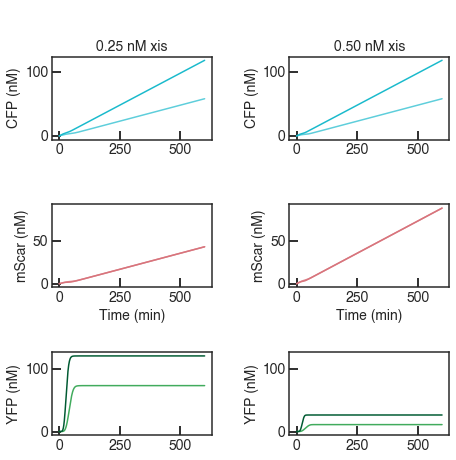

In [19]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']

figsize = (7,7)
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))  
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-simple-sim.svg')

In [20]:
m.get_parameter_dictionary()

{'k_i': 0.2,
 'a_i': 0.3,
 'd_i': 500.0,
 'k_int': 0.5,
 'a_r': 1.0,
 'd_r': 0.001,
 'a_e1': 0.05,
 'd_e1': 0.01,
 'k_exc': 0.05,
 'a_r1': 0.02,
 'd_r1': 0.0007,
 'a_s2': 0.02,
 'd_s2': 10.0,
 'k_e': 0.3,
 'k': 50.0}

In [21]:
m.write_sbml_model('sbml_files/integrase_excisionase_simple_updated2.xml')

True

In [22]:
from autoreduce.converters import load_sbml
from autoreduce.system import System
from sympy import Symbol
import sympy

int_xis_system = load_sbml('sbml_files/integrase_excisionase_simple_updated2.xml', outputs = ['Int', 'YFP', 'Exc'])

In [23]:
int_xis_system.x

[A, C_A, C_E, C_I, C_R, Exc, G_E, G_I, Int, U, YFP]

In [24]:
A, C_A, C_E, C_I, C_R, Exc, G_E, G_I, Int, U, YFP = int_xis_system.x

In [25]:
int_xis_system.f

[-A*Int**4*d_r + C_A*a_r,
 A*Int**4*d_r - C_A*Exc**4*a_e1 - C_A*a_r + C_E*d_e1 + C_I*k_int,
 C_A*Exc**4*a_e1 - C_E*d_e1 - C_E*k_exc,
 -C_I*Exc**4*a_s2 - C_I*d_i - C_I*k_int + C_R*d_s2 + Int**4*U*a_i,
 C_E*k_exc + C_I*Exc**4*a_s2 - C_R*a_r1 - C_R*d_s2 + Exc**4*Int**4*U*d_r1,
 -4.0*C_A*Exc**4*a_e1 + 4.0*C_E*d_e1 - 4.0*C_I*Exc**4*a_s2 + 4.0*C_R*a_r1 + 4.0*C_R*d_s2 - 4.0*Exc**4*Int**4*U*d_r1 + G_E*k_e,
 0,
 0,
 -4.0*A*Int**4*d_r + 4.0*C_A*a_r + 4.0*C_I*d_i + 4.0*C_R*a_r1 - 4.0*Exc**4*Int**4*U*d_r1 + G_I*k_i - 4.0*Int**4*U*a_i,
 C_I*d_i + C_R*a_r1 - Exc**4*Int**4*U*d_r1 - Int**4*U*a_i,
 A*k]

In [26]:
conservation_laws = int_xis_system.get_conservation_laws(num_conservation_laws = 8, debug = True)

In [27]:
conservation_laws

[[A, C_A, C_E, C_I, C_R, U]]

In [28]:
G_tot = Symbol("G_tot")
int_xis_system.params.append(G_tot)
int_xis_system.params_values.append(0)

In [29]:
states_to_eliminate = [U]
# f_cons = integrase_system.set_conservation_laws(conserved_quantities, states_to_eliminate)
assumed_conservation_law = [U+C_I+C_R-G_tot]
f_cons = int_xis_system.set_conservation_laws(assumed_conservation_law, states_to_eliminate)

In [30]:
sympy.Matrix(int_xis_system.x)

Matrix([
[  A],
[C_A],
[C_E],
[C_I],
[C_R],
[Exc],
[G_E],
[G_I],
[Int],
[YFP]])

In [31]:
reduced_model, collapsed_model = int_xis_system.solve_timescale_separation(slow_states = [G_I, Int, A,
                                                                                          Exc, C_E, C_R,
                                                                                          G_E, YFP])

Successful time-scale separation solution obtained with states: [G_I, Int, A, Exc, C_E, C_R, G_E, YFP]!


In [33]:
from autoreduce.utils import get_reducible
reducible_model = get_reducible(reduced_model)
reduced_model, collapsed_model = reducible_model.solve_timescale_separation(slow_states = [G_I, Int, A,
                                                                                          Exc,C_E,
                                                                                          G_E, YFP])

Successful time-scale separation solution obtained with states: [G_I, Int, A, Exc, C_E, G_E, YFP]!


In [36]:
from autoreduce.utils import get_ODE
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)

In [50]:
parameter_dict = {'k_i': 0.2, # Integrase expression rate
 'a_i': 0.3, # Binding of integrase to attP-attB
 'd_i': 500.0, # Unbinding of integrase to attP-attB
 'k_int': 0.5, # Integrase flip rate
 'a_r': 1, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r': 1e-3, # Binding rate of integrase to attL_attR site 
 'a_e1':0.05,
 'd_e1':0.01,
 'k_exc': 0.05, # Rate of excision (to flip attL_attR to attP_attB, with integrase-excisionase both bound)
 'a_r1': 0.002, # Unbinding rate of attP_attB, I, and E from the integrase-excisionase-attP_attB complex 
 'd_r1': 0.07, # Binding rate of attP_attB, I, and E to form the integrase-excisionase-attP_attB complex 
 'a_s2': 0.02, # 
 'd_s2': 10, # 
 'k_e': 0.3, # Excisionase expression rate
 'k': 50 # YFP expression rate
}

for key,val in parameter_dict.items():
    ind = ode_reduced.params.index(Symbol(key))
    ode_reduced.params_values[ind] = val

In [51]:
ode_reduced.params[-1]

G_tot

In [52]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        ode_reduced.x_init[0] = int_nm #Gi_tot
        ode_reduced.x_init[5] = exc_nm #Ge_tot
        ode_reduced.params_values[-1] = rep_level #G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result[1,:]
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result[3,:]
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result[6,:]

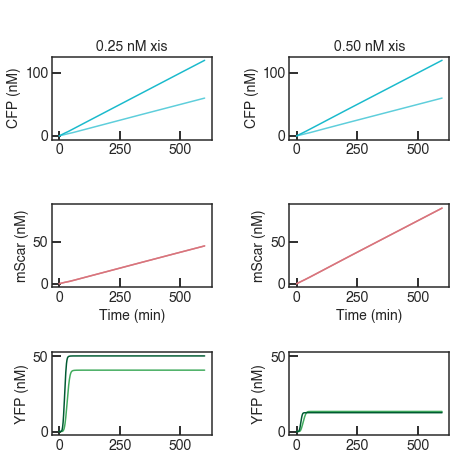

In [53]:
## Plot the results:

colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']
figsize = (7,7)
plt.close()
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

    
fig.tight_layout()
# fig.savefig('outputs/xis-int-yfp-sim-minimal2.svg')

Works ok, but not as good as the other one?

## Post process model from AutoReduce
Create an SBML file for the reduced model using BioCRNpyler:

In [60]:
from biocrnpyler import *
import sys
Int = Species("Int")
A = Species("A")
Y = Species("Y")
for p_symbol, p_value in zip(integrase_system.params, integrase_system.params_values):
    p_name = str(p_symbol)
    vars()[p_name] = ParameterEntry(p_name, p_value)
I_pl = Species("I_pl")
R_tot = Species("R_tot")
r0 = Reaction([],[Int], propensity_type = GeneralPropensity(f'{reduced_model.f[0]}', 
                                                            propensity_species=[I_pl], 
                                                            propensity_parameters=[r0_k_I]))
r1 = Reaction([],[A], propensity_type = GeneralPropensity(f'{reduced_model.f[1]}', 
                                                          propensity_species=[Int, R_tot], 
                                                          propensity_parameters=[a__, d__, k_int__]))
r2 = Reaction([],[Y], propensity_type = GeneralPropensity(f'{reduced_model.f[2]}',  
                                                          propensity_species=[A],
                                                          propensity_parameters=[k_Y__]))

model_crn = ChemicalReactionNetwork(species = [Int, A, Y, I_pl, R_tot], 
                        reactions = [r0, r1, r2])


model_crn.write_sbml_file("sbml_files/integrase_sbml_reduced.xml")

True